# **CS 6120 Final Project - Toxic comment classification** 


We will build a model which predicts a probability of each type of toxicity(toxic, severe_toxic, obscene, threat, insult, identity_hate) for provided comments

# Read the Data

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
nltk.download('wordnet')
from nltk.corpus import brown
nltk.download('brown')
from nltk.stem import WordNetLemmatizer

import sklearn
import string

import gensim
from gensim import models
train = pd.read_csv("/root/train.csv")
test = pd.read_csv("/root/test.csv")
test_labels = pd.read_csv("/root/test_labels.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


# Exploratory Data Analysis

### Tag Frequency

In [ ]:



brown_train = brown.tagged_sents(categories='news')
default_tagger = nltk.DefaultTagger('N')
unigram_tagger = nltk.UnigramTagger(brown_train, backoff=default_tagger)
bigram_tagger = nltk.BigramTagger(brown_train, backoff=unigram_tagger)
trigram_tagger = nltk.TrigramTagger(brown_train, backoff=bigram_tagger)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


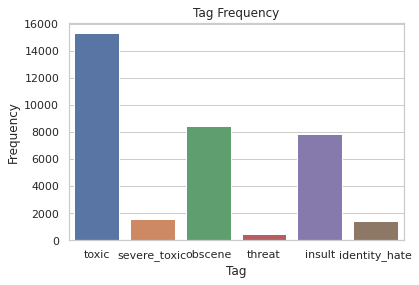

In [ ]:
train_plot = train.iloc[:,2:].sum()
print(train_plot)
plt.figure()
sns.set_theme(style="whitegrid")
sns.barplot(train_plot.index, train_plot.values)

plt.title("Tag Frequency")
plt.ylabel("Frequency")
plt.xlabel("Tag")
plt.show()

## Comments with multiple tags

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


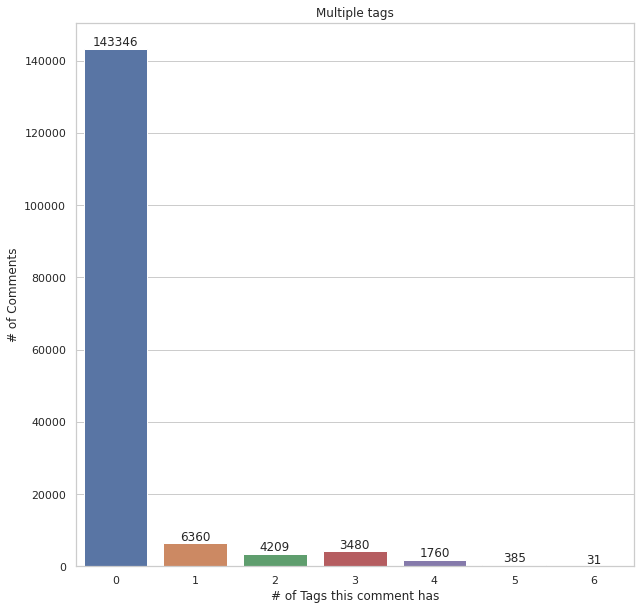

In [ ]:
rowsums = train.iloc[:,2:].sum(axis=1)
x = rowsums.value_counts()

plt.figure(figsize=(10, 10))
plt.title("Multiple tags")
plt.ylabel('# of Comments')
plt.xlabel('# of Tags this comment has')
ax = sns.barplot(x.index, x.values)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## Correlation

### Heatmap

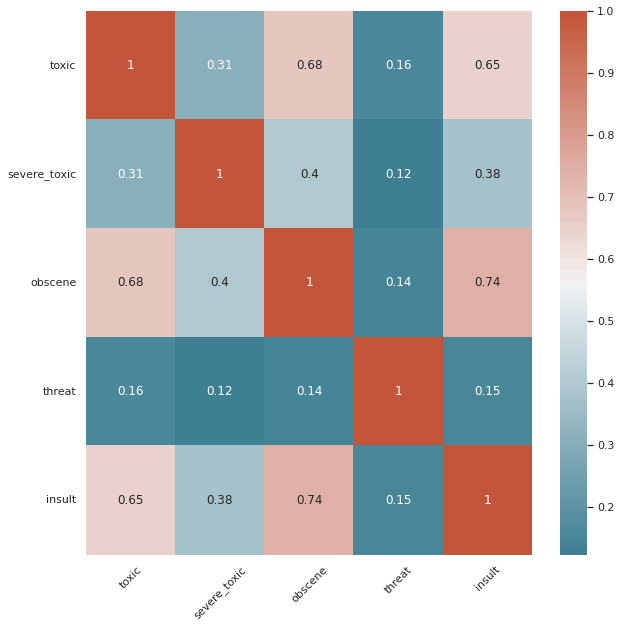

In [ ]:
corr=train.iloc[:,2:-1].corr()
plt.figure(figsize=(10, 10))
ax = sns.heatmap(corr,
            cmap=sns.diverging_palette(220, 20, n=200),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='center'
);

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=360,
);

### Correlation using Cramer's stat

In [ ]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194
import scipy.stats as ss
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [ ]:
temp = train.iloc[:,2:-1]
toxicCol, severe_toxicCol, obsceneCol, threatCol, insultCol, identityCol = train.iloc[:, 2], train.iloc[:, 3], train.iloc[:, 4], train.iloc[:, 5], train.iloc[:, 6], train.iloc[:, 7]

new_corr=cramers_corrected_stat(pd.crosstab(toxicCol, severe_toxicCol))
print("The correlation between Toxic and Severe toxic =",new_corr)

new_corr=cramers_corrected_stat(pd.crosstab(toxicCol, obsceneCol))
print("The correlation between Toxic and Obscene =",new_corr)

new_corr=cramers_corrected_stat(pd.crosstab(toxicCol, threatCol))
print("The correlation between Toxic and Threat =",new_corr)

new_corr=cramers_corrected_stat(pd.crosstab(toxicCol, insultCol))
print("The correlation between Toxic and Insult =",new_corr)

new_corr=cramers_corrected_stat(pd.crosstab(toxicCol, identityCol))
print("The correlation between Toxic and Identity Hate =",new_corr)

The correlation between Toxic and Severe toxic = 0.30850290540548614
The correlation between Toxic and Obscene = 0.6764644772231891
The correlation between Toxic and Threat = 0.15684415261524137
The correlation between Toxic and Insult = 0.6474661802275932
The correlation between Toxic and Identity Hate = 0.26588449189333063


## Word Cloud

In [ ]:
import codecs
from skimage.io import imread

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
#@title toxic_image
toxic_image = b'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAMAAADDpiTIAAAAA3NCSVQICAjb4U/gAAAACXBIWXMAAAcrAAAHKwExljYzAAAAGXRFWHRTb2Z0d2FyZQB3d3cuaW5rc2NhcGUub3Jnm+48GgAAAwBQTFRF////AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACyO34QAAAP90Uk5TAAECAwQFBgcICQoLDA0ODxAREhMUFRYXGBkaGxwdHh8gISIjJCUmJygpKissLS4vMDEyMzQ1Njc4OTo7PD0+P0BBQkNERUZHSElKS0xNTk9QUVJTVFVWV1hZWltcXV5fYGFiY2RlZmdoaWprbG1ub3BxcnN0dXZ3eHl6e3x9fn+AgYKDhIWGh4iJiouMjY6PkJGSk5SVlpeYmZqbnJ2en6ChoqOkpaanqKmqq6ytrq+wsbKztLW2t7i5uru8vb6/wMHCw8TFxsfIycrLzM3Oz9DR0tPU1dbX2Nna29zd3t/g4eLj5OXm5+jp6uvs7e7v8PHy8/T19vf4+fr7/P3+6wjZNQAAKf9JREFUGBntwQtgjvXiB/Dv+767u8xdIaOrSIgUcglx5BrlREKIjrJSnXWIkyjVUclJlz8H/xZSOV04f61IEklEJLfSmNnaYs3YZtu7ff/H6XTR9rx7f7/n9zzP79nezweoNKIbte4xdOL0eUtXJa3fvG3XvkOpmdl5fn9edmbqoX27tm1en7Rq6bzpE4f2aN0oGiEVRViTrqP+unjtzpRcCshN2bl28V9HdW0ShhB38jTtMXZm4sdH/DTFf+TjxJljezT1IMQ1anebtGDLKSp1asuCSd1qI0Rvka1Hzkk6RsscS5ozsnUkQnTUeNj8HX7awL9j/rDGCNFIWLv411Npq9TX49uFIcR5sX0eW59LR+Suf6xPLEKc42n78CY/HeXf9HBbD0IcUHtYYga1kJE4rDZC7OS9ZsZnxdRI8WczrvEixBbRg5cdp4aOLxscjRCLRQ1aforaOrV8UBRCLBM5cFkONZezbGAkQiwQOWDpSbrCyaUDIhGilKdb4km6yMnEbh6EqFIv4SBd52BCPYQo4O21spCuVLiylxch5jSclkwXS57WECHSfP1X+ely/lX9fQiREZtwlBXC0YRYhIiKm5vDCiNnbhxCRLRb4WeF4l/RDiFB8vTfwApoQ38PQsoXNX4/K6j946MQElhMQiYrsMyEKggxFjU5gxVcxv3RCClb5D1prATS4iMRUlr4hBRWEql/ikDIucLGJLMSOXJnOEJ+5R3xDSuZ70b7EPJfXXawEtrdHSFnNXmTldRbFyKk6ux8VlpnnqyGys0zOo2VWvoYLyqxTttZ6X1xHSqrxisY8m8rGqMy8j2Qy5D/yH3Ah0qn9XaG/GJ7G1QuUU8UMeQ3ip6KRiXS7SBDfufbHqgsaiwsYUhpS2qhUhiSzpAyZdyKiq/+2wwx9K8GqOD6ZTIkgOM3oSKLfpEh5VhYBRVW670MKdfBq1ExeR4sYEgQCqd6UQE1XMeQIH3cGBXOkBPUQFHGvk2rljz98OS7x90+dOAfru/Ytm2Hbr0H3DJi7MTJU+Ysemfj1+mF1MCPt6JiiVlEJ2Xvenfe5JvaNa2OIFSLu2pA/LNv7ciikxKrogK5eDedcXLTS5NvalMTUqpfOSD++Q0n6Iy9zVBh9M+m7Qq/Wj6lXxwUaND7wVe+yKftcoagYvDOKqGtSvYuGN0yHEr5Lrv1+Z1+2uspHyqAWkm0Uf7GJ/rVgkWq3TBj7Sna6MO6cL2rkmmX06sfuDYcFvNdNWllNu2S0h4uNzqf9tj9t+4RsElYp1nbSmiLgvFws4iXaYesN8Y0gM3q3vZqBu2wOAquVW8LrXfoyQ4+OMLTdsZeWm/7+XCpZt/RaslPtYOjWjy6j1ZLuQKu1DWL1jo852pooOWsA7TWyRvgQiMKaKXvn7kG2mj1+BFaqWgMXGc6LVScNCQcWvH2ebuIFnrMA1cJX0LrHJvVBBo6b8ohWmdZJFwkdh2t4l89wAdNeXq+UUCrbKwF14jbQ4uceLQRtFb3oTRa5MBFcIlW6bRG+p+rQntRfzpMa2S2hSu0z6IlDt8dBVcIG7WfljjZCS7QJYdWODA6HK7hvWUnrXC6O7TXO48W+HKoF+7S91NaIP9GaG5QAdXb0g8u1G0t1SscAq0NL6JyH3aHS7V/t4Sq+UdAY+OKqVjJqmvhYi1f81Ox4vHQVnwJ1SpecSVc7pJFhVTsPmhqKhX7+ApUAE1XU7Gp0NJUqpVxOyqIAclUayo0FE+liufXQIUR/XgBlYqHdsaVUKWtbVGhXLaWKpWMg2aGF1OhrAleVDR/PEaFiodDK4OKqE7J4rqogKo9U0R1igZBI70LqM6uTqigWn5CdQp6Qxtd8qhMzuQwVFieURlUJq8LNNE+h8qsaIAKrcaLxVQlpz200CqLqhzoiQqv7edUJasVNBCXTkWKZ0agEvDek09F0uPguNg9VCT9elQSrQ5QkT2xcFj4Oiqytj4qjarLqMi6cDhrCdXwT/OiMhmXRzWWwFHTqcaxrqhkWu6jGtPhoBFUI6kuKp0qiVRjBBzTtYAq+Kd4UBndkUsVCrrCIc2yqEJqZ1RSLb6mClnN4Ih631GFNXVQacUsoQrf1YMDIrZQgaIEDyqzkaepwJYI2O9lKpDSEZXc5V9RgZdhu9FUYHUtVHrR/6ACY2Czq/Jp3nQPQoAxRTTtTFvYqlYyTfOPQ8h/9M2laUfqwEbeJJqWPxAh/9Uxi6at9cE+s2jaj50R8ovmR2nak7BN/xKadawlQn7jgn00bTBscnE2zdofh5Bz1P6MZuU0gy1idtOsrXUQpG5z5zw6LgauFH3Ho3Oe6+lBcKqsoVn7qsEOi2hWUhUExXv3fp51/NFYuE616Zk869sHwhCU8Fdp1jLYYAjNWhqOoFywgT/bHA2XifyIP9t6MYLieYZm3QbLNTxBk571IChDf+SvVofBVbwr+atTdyA4CTQpOw4W86yjSQkISrX/5TlmwlWm8hxv1kRQRhfRnE98sNaDNKdoFIJy7SGeK78pXKTRaZ7r6PUISr88mjMNlmpdQFNy+yIYvulF/L234CLL+XvFT4UjGB2zaEpRe1goei9NyeqAYDTZxDL0hGt0Zhm+uAzBaHGMpnxTFdZ5kabkdUQwbjvJsnwdBpfw7mRZcscjGM1P0JTFsEw/mlLUD0GIXUYD98IlJtDAO3UQhA65NOVmWKR+Jk25A0G4/Bsa+bEuXKHmDzSS0gZB6FtEM040hDXepil/QRD6nqSxBXCFv9NY7lAEYVQJzXgPlhhCU+YiCAnFDKD4KrjAFX4GMsuD8v2ZptwGC9RIpxnLPChX1FIGtgku8CEDe6cqyvc0zfihDtRbSDPeD0e5GnzO8gyH9oawPF81Rbk8iTTjVSjXrYQmfF4V5bomjeVKrQLNRR9muY5fj3KFraEZvaFY1EGacKAuyjUgn0GYDc09wiAU3oZyxWyhCYerQK0naEJaE5RrrJ/BOHMRtNY4j8EouQ/lqrWXJsyFUq2LKC/7SpRrCoP0LrT2BoP0JMp1wVHKK24PhXzbKS+/C8rjmceg9YLGujFoi8NQnuYnKG93ONR5gPL8g1Ce8OUM3r5waMu3m8FbFY3ydMilvIehTONcyrsT5an6PkVMhrbupohNNVGeG4so7czFUGUF5T2C8tT9nEKy60FTtU9QyJ6GKM9oynsHinSivPc8KEf9vRT0D2jqRQpKbozyvEx5PaCEZzulpdZBOeruoaiSdtBSKz9FHWqEckR9SWm7fVBhNKX5O6MctXdR3Kce6Ohjijt4Pspx6SlKuwsKVE2jtKkoR80dlHE7NPRHythXH+UYTmk/1IB5syntfQ8Ci91GKWlVoZ2YFEr5ui7KsZDSnoVpTfIpK60eAqv2GSU9Ce3MpKTdtRFY9G7KKrwUZr1JWf5uCKzqZsoquBiaaZJPWTtrIrBmpylrNUzqQmnTEVjMx5S3Gpr5J+Vtr4HAbqe0XjDFu4Oy1nkRUMSHNKMPtNKDZnwWg8AWU9YeH8wYQVnp9RHYUppyIBwaCdtDU971IqCYrynrTpgQ9g0lFXdHYLNo0oPQSDxN+jsCa55LSUciIG8MZc1AYGNo1sn60EbdH2nWvQhsNGXdDWnhyZS03ouAbiiiaUugjQU0rXggAnuFktKiIWsCJWWcj4BanqR5Je2hiauKaV7u1Qioyj5Kuh+SIlMop/gGBNQghSps9UAPm6jC900Q0BV5lJNZBXLuoaQnEFDVnVRjNLRwG9X4ugYCmkBJUyAlKo1yDkUhEN8aKpJeDRqokkpFPgxHIJ7NlHOiOmRMpqQbEdDLVGYONDCbyvwvAmrlp5xHICEmg3LeQkATqE7hpXDcRWeozr0I6DnKya4JcQmUk9sYgVyZT4XWwHHvUqGCqxFI9TTKmQ1hUZmU8xACqbqfSvWFw3pTqe9qIJDhlJMTC1HjKWdvOAJZSrUORsBR4fuo1lsIaD3lJECQZz/lXI9AxlK1BDjqfqoWj0AuL6SU1HCI6U85yxBIizyqdup8OKjeSapW0A6BPEk5t0PMBko5eR4CiPma6iXCQYuo3qFYBFAlhVK+hJB2lDMJgSyhBUquhWOuLqEFViKQwZTTEyJWUMpOHwIYSUts88Ahni20xD0I5D1KSYKAOD9llFyLAJqdpjXGwCEjaY2Ctgjg4jOUcgWCN5dSFiKAqN20SEYsHFEtjRY5VB0BPEopSxC02BzKOF4bATxJyzwDRzxFy7yMAKIOUUbB+QhWAqWMQwCtimiZwmZwwCUFtEzJdQigL6XMRpB8RynjUw+M+T6nhZLggP+jhfZGIIC3KSMrCsHpTxklbRDAfbTUANjuRlpqBgKIO0MZIxCcVZTxDgKIO01LfRsJm0UcpKUKmiOAlyljA4LS0E8ZVyOANbTYFNgsgRbb5IGxpkWUcSmCMY0yPkAAw2i10w1hq/NzaLU/IYBEyngKQfAmU0ZXGKuVQcstha1eoeVONoSxy0soISMc5etFGZsQwBLaoBNsdG0Jrfc2AlhJGYNRvpWU0QfGutMOX3hhG8/ntMNgGGtDGe+hXPUKKeELGIv+hra4E7YZQ1sci4WxNZRQ3BjlSaCMwTD2JO2RWQM2qZ5Be7wEYx0pYwbK4TlICV97YOjiItrkOdjkGdqkuBWMfUQJKV4E1o0yRsDYq7RLUXPYolkh7bIaxnpSRh8ElkgJh3ww1LyYtlkLWyTRPtfA2FZKeAMBRZ6khPEwtpI2ugk2GEAbrYWxAZSQWwWBDKCE1AgYalNCG30XBctFfks7dYEhz25KGIpAllLCfTD2L9pqGiw3hbbaCGO3UsJKBBCVQ3GZMTB0Le2V2wgWa3ia9uoFQ96DFJdXFcYGUcJUGFtHm70Giy2lzbbC2BhKuBXGllNcdnUY6kbbdYalOtF2/WEo/AjFvQVD0acobjaMbaLtdnphIe8XtN2XHhiKp7j8ajAymOJKmsDQH+iACbDQnXTALTBUI4/ihsPICor7AMa20QHHa8IyNTLpgL1eGEqkuHdgIOY0xd0CQ4PoiOdhmXl0xAgY6kxxZ6qjbDdTXGYEDO2gI/xXwCItiuiIAx4Y2k9xI1C2FRT3NAx1okM+hEXW0SG9YehBinsHZfJlUVwzGFpOpwyBJQbTKathqG4hhZ2KQFk6UtwnMHReIZ1yOBoWiEqmU4qbwtCbFNcdZZlJcSNhaDqd81dYYDqdMweGelHc31CWbRSWHQ0jYal0Tl5jKHdBLp1zIhpGvMkU9hXKULeEwhbA0M100utQbgWdNAaGZlJcI5R2G8X1hKENdFRXKNaFjtoBQy0obhxKW0phmT4YuYLO2uWDUr4v6ayOMLSHwlaiFG8mhb0EQy/RYROh1J/osOUwNJ3CssPwe1dT3PUwUv0UHXaiFhSqdZwOKzwPRi6luM74vekU9r0XRuLpuBeg0Hw6bjoM7aSwx/F7n1LYCzC0n47zXwllWvrpuGNhMPIXCtuB36npp7CuMNKeGtgAZT6iBnrBSFMKK6mPc/WlsDQvjDxDHQyFIrdQB4tg6HMKG4xzPU5hz8OIJ4U6OBINJaKPUAdZETDyAIU9jXNtoLCeMNKJengUSsygHvrCyCUU9inOEZZLUacjYeTv1EN+HBSIy6MeXoWhQxR1JhK/dTWFrYYRbxo1sRIKrKQmTkbByAsU1hG/dS+FTYSRrtRGd5jWndq4CUb6U9iD+K03KOxCGHmR2vjKB5N8X1EbK2CkagFF/RO/lUpRB2DEl0F9TIJJk6iP0zEw8iFFpeM34ijsORjpSY1kxcCU6CxqZCiMJFBYU/xqOIX9AUYWUicjYMow6uSfMHIlhd2GX82nqLwoGAg7QZ2sgylrqJP8ajByjKJewK92UtQaGOlErZyAKceolYEwspiiduIXkX6KeghGHqVW0mFKMrUyH0ZGUZQ/Ej9rQ2GdYeRTaiUZpuynVg7CyCUU1gY/G0lRhdEwEOunVl6AKc9RL3EwkklRI/GzORS1FUZuol5awZRm1Ms4GHmXoubgZ+9T1FwYeZFaWQmTllErb8DIQxT1Pn6WRlE3w8g31MnmaJgUuZE6OeGFgesoKg3/VZvCGsBAU+pkWy2YVnMbddIOBqIKKKo2fnI9RR2GkfHUyBvRUCD6DWpkKox8RlHX4yfxFLUcRt6kPh71QAnPo9THRzDyLEXF4ycLKeoeGPBmURf5t0KZW/Opi4IqMHAzRS3ET7ZSVEcYaEVd5HaBQl1yqYueMHAhRW3Ff3hOU1R1GLiTmjhzA5S64Qw1MQUGPKcp6LQHZ11IUYdhZCH1UNgPivUrpB7ehpHPKOpCnNWTolbDyJfUgv9mBCe83nmRCM7NfmrhGIwspKieOGscRc2GgRg/tTAB5al/4/R3dqWc4r/lpu7+18yBjVCeCdRDQxiIp6hxOGsWRQ2HgeuohQUIyNdzYSpLyVjaLwIBLaAWboKB7hQ1C2e9SlEtYeB+6mBLBALo8EIGDWQt6oEAIrZQB0/AQF2KehVnbaSgwnAYWEENpDeAses3MKDt/WGsQTo1sA5GvqegjTgrhYK+gpHv6Dz/dTDUYyPL9cVAGLrOT+dle2BgLQWl4N/C/BS0HAbqUAN/g5E6bzAoHzSGkb9RA81g4FkK8ocBaEpRj8BAbzrv22gYGJLJIOWMh4Hob+m8ETAwgaKaAuhGUaNgYDKd1x1lq76CAtY2QNm603mzYaA3RXUDMJqiusLAAjruHyhbo90UktISZfsHHfdPGLiMokYDeISi4mBgI532Qw2UqVUqBZ3siTLV+IFO+xoGokoo6BEASyioyAcDmXTan1GmXjkUVjgKZfoznVbgg4F0CloCYC0FJcNAbTrt+xiUpcsZSij5I8oS8z2ddjEMbKGgtQB2UtBHMNCJTpuMsjTPopQzXVGWyXRaXxh4jYJ2AkihoCUwMJYOOxaFMjRMoaQfr0AZoo7RYQ/AwBMUlAIgj4IegYGn6bB4lCF6F6UdrYsyxNNhC2BgAgXlAdEUNQoG/kVnna6OMsylCf9EGaqfprM2wkBviorGBRTVHQa+pLMWowxdS2jGcJRhMZ2VDAPNKeoCtKaoVjCQTmd1QGlVv6MpWeejtA50Vj4M1Keo1uhBUQ1RNk8RHbUHZZhPk95FGfbQWbEoWxhF9cAfKSoKZatDZ92H0poW0axOKO0+OusyGMimoD9iIgXlwkALOut8lLaIpn2E0s6ns7rAwCEKmojpFHQEBq6no3ajtIuKaF53lLabjhoKA1spaDrmUdAOGLiVjpqD0pZQgU9R2hw6Kh4G1lDQPCyloLUwcC8d1ROl1CqkCm1QSk86ajYMvEpBS7GKgl6Dgdl0Ul4kSplAJZ5CKZF5dNJiGJhLQauQREHzYeAfdFISSttIJQ57UEoSnbQGBqZRUBLWU9BMGFhNJz2OUhqXUI2OKOVxOukLGJhIQeuxmYKmwsDndNIwlPJnKvIcShlGJx2DgTEUtBnbKOhBGDhMJ12JUlZTke0o5Uo6qciDso2goG3YRUGTYCCfDiqKQCnfU5HCSPxeRBGdVBdlu4WCdmEfBU1A2TwFdNBelHIBlbkGpeylkxqhbAMpaB8OUdAdMLCHDnoNpQymMveglNfooNMelK0PBR1CKgXdBgNv0kG3o5THqcxilHI7HfQFDPSgoFRkUtAtMHA3nVNUC6UspjJrUEqtIjrnWRjoTEGZyKaggTDg+4KOWYzS3qYyW1DaYjrmWCwMXENB2cijoD4wcpWfDtkRjdI2UJn9KC16B51yE4y0oaA8+CmoBwx1+o6O+LwxyrCLymSgDI0/pyN+HAZDLSjIDz8F9YCxavMP03Ypd3lRlhQqU4CyeCd+T9udeucCGGtBQX7kUVAfBFTvxltt1b02DGRTmTMw0KjfhLvsdHsLLwJpQ0F5yKaggXCJ76hMGlziGgrKRiYF3QKX2EZlvoJLdKagTKRS0G1wiSQqswEu0YOCUnGIgu6ASyynMm/BJfpQ0CHso6AJcIknqcxzcImBFLQPuyhoElxiMJUZDpe4hYJ2YRsFPQiXaEhlLoJLjKCgbdhMQVPhFkepyA9wizEUtBnrKWgm3GIlFfkX3GIiBa1HEgXNh1vcRUXug1tMo6AkrKKg1+AWdYqoRPH5cIu5FLQKSyloLVzj/6jEh3CNVyloKeZR0A64xm1UYixcYw0FzcN0CjoC16hymgrk14BrbKWg6ZhIQblwj79Rgb/DPQ5R0EQMpagouEadUzQt7zy4RzYFDUUPimoI93iMpj0N9wijqB5oTVGt4B41s2nS6bpwj/oU1RqNKKo7XCSeJiXARZpTVCNEU9QouIjnI5qy2QsX6U1R0UAuBT0CN2mSQxNyL4GbTKCgXAApFLQErjKOJtwDV3mCglIA7KSgj+Aur1Da6x64ymsUtBPAWgpKhruEf0BJGyPhLlsoaC2AxRRU5IO7VNtBKftqwmXSKWgxgL9SVBxc5rxDlHCsCVwmqoSC/gpgFEV1hdvU30Zhe+PgNpdR1CgAXSlqFFynyioK2lATrtOboroCaEJRj8B9fPMpZHkk3GcCRTUBEOanoOVwo5t/YNBy7oQbPUtB/jD82xEK+gquVP8dBumjJnCltRR0BGd9TEGF4XCnkekMwolJHrjT9xT0Mc5KpKiWcKno+9JZjuNTq8Gl6lJUIs6aSVHD4VrR9x1lAOl/qQrX6k5RM3HWWIqaDRfzdHnpB5bpx0U9fXCxeIoai7N6UNRquFtYn2c+zuE5Tn/y3IAIuNtCiuqBs5pS1GG4n7fZiKlzFr310UdvLXr64dube+F+n1FUU5zlOUVR1RGiHc9pCjrlwX9soaiOCNHOhRS1BT9ZQFH3IEQ7N1PUAvxkEkUtR4h2nqWoSfhJN4o6jBDtfEZR3fCT2hTWACGaiSqgqNr4r2MUdTNCNHMdRR3Dz5Ioai5CNPMQRSXhZ3MoaitCNPMuRc3Bz0ZSVGE0QvSSSVEj8bPWFNYZIVq5hMJa42eRfop6CCFaGUVR/kj8YgdFrUGIVhZT1A78aj5F5UXBNarf/tjrfx/aAAJiez+6dPbYhnCPYxQ1H78aRmF/gEtE3PcDzyrZOLYaghI+8K0CnpX3eDW4xJUUNgy/akxhz8EdfEn8Re7Snj6Up+28H/iLvTXhDgkU1hi/kUpRB+AOz/Mc2e/Gt4ChhqNeTeM5NkTAFT6kqFT81usUdiHc4GaW9v3rj9zapgrO4bvoxskL9rG0p+EGVQso6nX8VjyFTYQLRB2mgZKUTWtWLHjmkelPvfDKWx/sOUMDhZfCBfpTWDx+qx2FrYYLPEzTVsMFXqCwdvitsFyKOh0J7TU4TfN6QX+HKCo3DOdYT2E9ob1XqMCeMOjuEgpbj3M9RmHPQ3ftS6jC3dDdAxT2GM7Vh8LSvNDcp1TieE1o7nMK64NzxfoprCv0NpyKzIPemlKYPxa/s4nCXoDWYo5SkaJm0NpfKGwTfu9hCvveC53NoDJroLWdFPYwfq8txV0PjV2QR3X6QGOXUlxb/J4ng8JegsaWU6F9YdDXdArL8KCURArL9EFbHanUvdDXHgpLRGnDKK4ndOX5nEpl1YauWlDcMJRWu5jCFkBXo6jYfOhqJoUV10YZPqOw7GjoqWoaFfO3gJ68yRT2Gcoyg+JGQk+PU7kPoKdeFDcDZbmG4j6BlprkU73+0NKbFHcNyuI9TnHNoKM3aIGD4dBQ3UIKO+5FmZZR3NPQUBda4n5o6EGKW4ayDaa4zAhox7uDlsiuC/3sp7jBKFv0KYq7BdoZS4u8DO10prhT0TCwnOI+gG6qfU+L+K+EbhIpbjmMDKK4kibQzFO0zIfQTI08ihsEI1E5FDcbermogNYZBL3EU1xOFAwto7js6tDK27TQtxHQSfgRilsGYwMpYSp00p2WSoBOxlDCQBiLPElxmTHQh283LXWyPvThPUhxJyMRwFJKuA/6uIsWWwh93EoJSxHIAEpIjYAuavxAixW3hi48uylhAAKJPEkJ46GLZ2m5DdDFAEo4GYmAEinhkA96uLSQ1hsCTWylhEQE1o0yRkAP/6INvouEFnpSRjcE5jlICV97oIPetMUUaOEjSjjoQTkSKGMwNBD2NW1x6jxooCNlJKA89Qop4Qto4B7aZAk0sIYSCuuhXCspow8cV+sEbVLSFo5rQxkrUb5elLEJjvs7bfMJHLeSMnqhfN5kyugKhzUvon3+CIddXkIJyV4EYRplfACHJdFGR6LhrETKmIZgNPRTxtVwVF/aahoc1bSIEvwNEZRVlPEOnBR+gLY63RBOepkyViE4/SmjpA0cNJk2S4SD4s5QRn8Ex3eUMj71wDF1fqTNStrDOW9TxlEfgpRAKePgmJdou089cEpfSklAsGJzKON4bTikpZ/2Gw6HRB2ijJxYBG0upSyEQz6kA47GwBmPUspcBC/OTxkl18IRg+iIGXDExWcowx8HASsoZacPDoj4lo7IvQBOeI9SVkBEO8qZBAck0CHL4IDBlNMOQjZQysnzYLv6J+mUDrBdlRRK2QAx/SlnGWz3Dzpmqwd2e5Jy+kOMZz/lXA+btSmmc0bCZpcXUsp+DwSNp5y94bDXx3TQsSqw13rKGQ9RUZmU8xBsdTMdNQu2Gk45mVEQlkA5uY1ho6hkOio/DjaqnkY5CRAXk0E5b8FGU+mw12Gj5ygnIwYSJlPSjbDN+afotOtgm1Z+ypkMGVFplHMoCnb5Xzpuuxc28WymnLQoSLmHkp6ATa4uofPugE0mUNI9kBOZQjnFN8Aem6mB9GqwxRV5lJMSCUkTKCnjfNhhGLXwBOxQZR8lTYCs8GRKWu+F9aJTqIUzTWGDVygpORzSxlDWDFjvEWpiJaw3mrLGQF7YN5RU3B1Wa5RLXXSF1ZrnUtI3YTBhBGWl14fFllEbO72wVszXlDUCZnh3UNY6LyzVoYT6uBPWWkxZO7wwpQulTYeVPFupkYzqsNLtlNYFJr1JWf5usNBIauVvsFCz05T1Jsxqkk9ZafVgmSrHqJWCi2CZ6N2Uld8Eps2mtPc9sMosauYdWGYhpc2GeVXTKG0qLBKXT930gEWGU1paVSgwmtL8nWGN16md3T5Y4tJTlDYaKni2U1pqHVihMzV0F6wQ9SWlbfdAiU6U954H6nm/oIZ+qAELvEx5naDICsp7BOqNoZaehXqjKW8FVGmcS3l3QrVq31NLhZdCtRuLKC23MZR5gPL8g6DYk9TUaijWIZfyHoA6vu2Ul98FSl14hrrqBaWan6C87T4o1LqI8rKvhEpvUVtfh0GhC45SXlFrKPUETUhrAnWup8buhjq19tKEJ6BW1EGacKAuVPHtosaO14QqMVtowsEoKNathCZ8XhWKTKDW5kGRsDU0oaQblFtIM94PhxKxmdRaUTMo4UmkGQuhXo10mrHMAxWeoebegxJP04z0GrDAEJoyFwpcUkjd9YECf6YpQ2CJt2nKX2DeampvXxhMG1VCM96GNepn0pQ7YNYNdIF7YVbfIpqRWR8W6UdTivrBnLA9dIGs2jCnQy5N6QfLvEhT8jrClLvpCvNhSvMTNOVFWCd6L03J6gATap6gK/hbwIQWx2jK3mhYqHUBTcntC3nz6BIfQF7HLJpS0BqWepDmFI2CrMuL6Bb9IatfHs15ENbyrKNJCZD0Hl3jYDjkjC6iOes8sFjDEzTpWQ9k3EgXuR9SEmjSiYaw3BCatTQc4sL200Wy60Cc5xmaNQQ2WESzkqpAWG+6yr0QFv4qzVoEO8Tspllb60DUQrrKJxBVZQ3N2h0DW1ycTbP2x0GM7zhdpeR8iKn9Gc3Kvhg26V9Cs461hBBfMd3lMgi5YB/NKukP28yiaT92hpAMuks1iGh+lKbNgn28STQtfyBE7KKr5EBExyyaluSFjWol0zT/OAiYQld5CQL65tK05Fqw1VX5NG+6B0GrkkEXyWuA4I0pomn5V8Fmo6nA6loI2ji6yDQELfofVGA0bPcyFUjpiKANzaVLFN6FoF3+FRV4GfaL2EIFihI8CFarHXSF/Z0RtJGnqcCWCDig3ndUYU0dBO2GtdTepoEeBCtmCVX4rh4c0SyLKqR2RvDaLC+ixor/eS2C1+JrqpDVDA7pWkAV/FM8CF6TeaepqbyXLoaAO3KpQkFXOGYE1UiqCwG1pmVQQz/MqAsBVRKpxgg4aDrVONYVIqLu+oaa+XZiNES03Ec1psNRS6iGf5oXIrxDNlIjG2/2Qsi4PKqxBM4KX0dF1taHmEtmp1ILRx+/BGKqLqMi68LhsNg9VCT9egjy9XmjgA47s6K3F4JaHaAie2LhuLh0KlI8MwKiak/aSQdtv7smRHnvyaci6XHQQKssqnKgJ8RdPu1LOmL7lEshru3nVCWrFbTQPofKrGgACRclbKW9Sjbf3wQSarxYTFVy2kMTXfKoTM7kMMi44L5PimkT//q7G0CGZ1QGlcnrAm30LqA6uzpBznljl39Pyx1LHFkXclp+QnUKekMjg4qoTsniupB1xX2rc2iZH9++uxlkVXumiOoUDYJWhhdToawJXkgL6zDtowIql7/2L1d7Ie+Px6hQ8XBoZlwJVdraFmbE9Eh47UAJFSneu/SBrpEw47K1VKlkHLQTT6WK59eASVWvm7Tky0KaUrhj0d0dYmBS9OMFVCoeGppKtTJuhwKRbe98cd23BRRW8M3aF8ZeFQEFBiRTranQ0lQq9vEVUMTbsNPwqQveP5DPcuUfeP9/pg7v2MADRZqupmJToan4EqpVvOJKKOU579rBIycmPPrM/yx9Z91nXyX/kJt3/PCerR++u+x/np2ZMHHk4GvP80CpSxYVUrH7oK1xxVSsZNW1cLGWr/mpWPF4aGx4EZX7sDtcqv27JVTNPwJaG1RA9bb0gwt1W0v1CodAc73zaIEvh3rhLn0/pQXyb4T2uuTQCgdGh8M1vLfspBVOd4cLtM+iJQ7fHQVXCBu1n5Y42Qmu0Cqd1kj/c1VoL+pPh2mNzLZwibg9tMiJRxtBa3UfSqNFDlwE14hdR6v4Vw/wQVOenm8U0Coba8FFwpfQOsdmNYGGzptyiNZZFgl3mU4LFScNCYdWvH3eLqKFHvPAbUYU0ErfP3MNtNHq8SO0UtEYuFDXLFrr8JyroYGWsw7QWidvgCs1+45WS36qHRzV4tF9tFrKFXCpeltovUNPdvDBEZ62M/bSetvPh2tFvEw7ZL0xpgFsVve2VzNoh8VRcLPR+bTH7r91j4BNwjrN2lZCWxSMh8tdlUy7nF79wLXhsJjvqkkrs2mXlPZwvVpJtFH+xif61YJFqt0wY+0p2ujDuqgAvLNKaKuSvQtGtwyHUr7Lbn1+p5/2esqHiqF/Nm1X+NXyKf3ioECD3g++8kU+bZczBBXGxbvpjJObXpp8U5uakFL9ygHxz284QWfsbYYKJGYRnZS96915k29q17Q6glAt7qoB8c++tSOLTkqsioplyAlqoChj36ZVS55+ePLd424fOvAP13ds27ZDt94DbhkxduLkKXMWvbPx6/RCauDHW1HhNFzHkCB93BgVkOfBAoYEoXCqFxVT670MKdfBq1FhRb/IkHIsrIKKrF8mQwI4fhMquPpvM8TQvxqg4huSzpAyZdyKSqHGwhKGlLakFiqLbgcZ8jvf9kAlEvVEEUN+o+ipaFQurbcz5Bfb26DS8T2Qy5D/yH3Ah8qo8QqG/NuKxqisOm1npffFdajEPKPTWKmlj/Gicqs6O5+V1pknqyGkyZuspN66ECFnddnBSmh3d4T8l3fEN6xkvhvtQ8ivwsYksxI5cmc4Qs4VPiGFlUTqnyIQUlrkPWmsBNLiIxFStqjJGazgMu6PRoixmIRMVmCZCVUQEljU+P2soPaPj0JI+Tz9N7AC2tDfg5AgtVvhZ4XiX9EOISLi5uawwsiZG4cQUbEJR1khHE2IRYgMX/9Vfrqcf1V/H0KkNZyWTBdLntYQIeZ4e60spCsVruzlRYgC9RIO0nUOJtRDiCqebokn6SInE7t5EKJU5IClJ+kKJ5cOiESIBSIHLsuh5nKWDYxEiGWiBi0/RW2dWj4oCiEWix687Dg1dHzZ4GiE2MJ7zYzPiqmR4s9mXONFiJ1qD0vMoBYyEofVRogDPG0f3uSno/ybHm7rQYhzYvs8tj6Xjshd/1ifWIQ4L6xd/OuptFXq6/HtwhCikcbD5u/w0wb+HfOHNUaIjiJbj5yTdIyWOZY0Z2TrSITorXa3SQu2nKJSp7YsmNStNkJcw9O0x9iZiR8f8dMU/5GPE2eO7dHUgxB3CmvSddRfF6/dmZJLAbkpO9cu/uuork3CEFJRRDdq3WPoxOnzlq5KWr952659h1Izs/P8/rzszNRD+3Zt27w+adXSedMnDu3RulE0Ko3/B5H+3PtfXYbtAAAAAElFTkSuQmCC'

In [ ]:
f2 = open("toxic-sign.png", "wb")
f2.write(codecs.decode(toxic_image,'base64'))
f2.close()
img2 = imread("toxic-sign.png")
# img = img.resize((980,1080))
hcmask2 = img2

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
#@title severeToxic-image
severeToxic_image = b'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAMAAADDpiTIAAAAA3NCSVQICAjb4U/gAAAACXBIWXMAAA3XAAAN1wFCKJt4AAAAGXRFWHRTb2Z0d2FyZQB3d3cuaW5rc2NhcGUub3Jnm+48GgAAArhQTFRF////AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD8p07wAAAOd0Uk5TAAECAwQFBgcICQoLDA0ODxAREhMUFRYXGBkaGxwdHh8gISIjJCUmJygpKywtLi8wMjM0NTc4OTo7PD0+QEFCREVGR0hJSktMT1BSU1RVVldZWltdYGFiY2RlZmdoaWprbG1ub3BxcnR1dnd4eXp7fH1+f4CBgoOEh4iJioyOj5CRkpOUlZaXmJqcnZ6foKGio6Slp6ipqqutrq+wsbKztLW2t7i5uru8vb6/wMHCxMXGx8jJysvNzs/Q0dLT1NXW19na29zd3t/g4eLj5OXm5+jp6uvs7e7v8PHy8/T19vf4+fr7/P3+6vNxvQAAGYNJREFUGBntwY9jlPV9B/B3Lo/kCSWKMCSxYesAN8MQHpRS5ZehUyyFoo10Ywbrj7lJ0UYwA1HxqpYfCo4hWm/UDYxXFBREqIgIc5hGBdMaMuUBE0kw5O79b2x2zgG5e57v3fM893zvns/rBaGLihvW7Wrt7m7dte6GCoioqVnbxW90ra2BiBLzodM8z+mHTIjIqN7HAfZVQ0TE+HZm0D4eIhKq25lRezVEBJj7mMU+E6L0PcSsHoIoeTWnmdXpGohSt5YO1kKUuIouOuiqgChtN9DRDRClbR0drYMobbvoaBdEaWulo1aI0tZNR90QpY0u4MGEux7e9OK6ZbcMh9AWXSBfY9a082upPXcMgtATXSA/NWv7eK6jC2IQOqIL5KX+BC+UHAqhIbpAPhb3c6DWOgj90AXyEGdGnaMgtEMXyF2cWbxdCaEbukDO4sxqA4Ru6AK5ijO79EQIzdAFchSnkxYIzdAFchOns6sg9EIXyEmcLpog9EIXyEWcbvZC6IUukIM4XaUGQWiFLqAuTgWjILRCF1AWp4prIIIy/JZl617c9PBdE5ADuoCqOJVMhwjEoDv2pPi19jVjoIouoChONeMgAhBbcJTn6ltbAzV0ATVxKhoO4b+hSV7oRD2U0AWUxKnoZBmE7+paOVD/YqigC6iIU9XzEL4b1cmM4lBAF1AQp7JbIfxW+TaziMMdXcBdnMq6LoXw2wZmFYcruoCrONU9COG3iWlmF4cbuoCbONV9WgXhtxY6icMFXcBFnOrScyH8dhWdxeGMLuAszhwsg/BdE13E4Ygu4CjOHDxXBuG7vXQThxO6gJM4c5AwIHw3KEVXcTigCziIMwcJA8J/o6ggjuzoAtnFmYOEARGAa6gijqzoAlnFmYOEARGE6VQSRzbddNSNbOLMQcKACMQ4qokji1Y6akUWceYgYUAEYzgVxZHZLjrahczizEHCgAhI2UkqiiOjdXS0DhnFmYOEARGY56kqjkxuoKMbkEmcOUgYEMG5lcoWI4OKLjroqkAGi5mDhAERoEu7qKq/HhmspYO1yKC+n+oSBkSgHqSyEzUYqOY0szpdg4FqTlBdwoAIVtWnVLYWGTzErB5CBmupLmFABG1umqr6xmAgcx+z2GdioDF9VJYwIIL3IJWtQQbV7cyovRoZrKGyhAFRAGXPUVU7MhnfzgzaxyOTdqpKGBAFYSSoagIyqd7HAfZVI5MJVJUwIArESFDRXcjIfOg0z3P6IRMZ3UVFCQOiYIwE1TyMLGrWdvEbXWtrkMXDVJMwIArISFDJJmRVccO6Xa3d3a271t1Qgaw2UUnCgCgoI0EVL8KjF6kiYUAUmJGggnXwaB0VJAyIgjMSdLcMHi2ju4QBEQIjQVe3wKNb6CphQITCSNBFajg8Gp6ii4QBERIjQWd74NkeOksYEKExEnR0Bzy7g44SBkSIjAQdHB0EzwYdpYOEAREqI8HsFsAHC5hdwoAImZFgNskYfBBLMpuEARE6I8HMWofCF0NbmVnCgNCA8Rwz6ayDT+o6mclzBoQWypalOcDbo+CbUW9zgPSyMghdzP2U50tvqISPKjekeb5P50JopOrBLp6jZSJ8NrGF5+h6sApCL5fe+vxJfiW1t+kqBOCqpr0pfuXk87deCqGhsuHjpl8zahACM2jUNdPHDS+DEEIIIYQQQgghhBBCCCGEEEIIITQ16Pur97R98UXbntXfH4S8VNbNbFjkomFmXSWEfqof7+I3uh6vRq6G/uTfeqik599+MhRCKxUrT/M8p1dWIBfmz04yByd/ZkLoo3ovB9hbDXXT2pmj9mkQupjQzgzax0PVwj7mrG8hhB4smxm1V0NNE/PSBKEDy2YWeyug4uY085K+GSJ8ls2sHoaCiT3MU89EiLBZNrPruRzuXmfeXocImWXTyTq4mk0PZkOEyrLpqKcSbvbRg30QYbJsupgNF7X0pBYiPJZNN2vg4qf05KcQobFsutoDF7+mJ7+GCItl010bXOynJ/shQmLZVPAFXPyenvweQk3l7CW/+NWu1u7u1l2/+sWS2ZXwyLKp4gu4+JKefAmhoHbR1h6ep2drYy08sGwqaYOLTnrSCeHmokUHmdHBRRchT5ZNNXvg4iA9OQjhrOzHbcyq7cdlyIdlU9EauGihJy0Qjma/S0fvzkbuLJuqZsPF/fTkfggHI3fS1c6RyJFlU1VPJVzU0ZM6iOwmtVNB+yTkxLKpbB1cHaEHRyCya+ilkt4G5MCyqazncrhaQA8WQGQTe5TKHo1BlWVT3cNwFzvMvB2OQWRhbmUOtppQY9lUt7cCCurTzFO6HiILM8mcJE2osGyqa6+Gkp8zTz+HyMJMMkdJE+4sm+rsCVC0mXnZDJGFmWTOkibcWDbV2RZUGY8zD48bEJmZSeYhacKZZVOdbSEHf9PLHPX+DUQWZpJ5SZpwYtlUZ1vIyZ9uSjMH6U1/CpGFmWSekiays2yqsy3kamK8jYra4hNRlMpH1E2ds/C+Vc9s3b3vnffaPu482dP/5Ymjh/du/9eNv1zZdPdPfvTX104YPRSemEnmLWkiG8umOttCPurm3v3oOheP3j23DsWnZnrjYy+19VPJZ3v/ZenNVhXyYibpQdJEZpZNdbYF8bXKCfOXPrv/c+ahY/f6+344vhI5MZP0JGkiE8umOtuCAGrr73xy+7E0PUq371j3078qgxozSY+SJgaybKqzLUTe5Q3rj9JPn/36HisGV2aSniVNXMiyqc62EG3D5q4+wiCceuln3zXgxEzSB0kT57NsqrMtRNiQG1cdSDNAX7zywLQKZGEm6YukiXNZNtXZFqLKnLHizbMsgN5dy6fHMJCZpE+SJv6fZVOdbSGaxjXt6GUBdTzxvTKcz0zSN0kT/8eyqc62EEWX3fM2C+/YoxbOEdtKHyVN/C/LpjrbQvSY87edZUjeX16H//MofZU08RXLpjrbQuRc99Qphurd+0fjKw30WdIEYNlUZ1uImDHNH1ADv/2Hb+PqXvotacKyqc62EClDb3uDukjv+gP9l/yeTXW2hQgxbnrhDMU5bAvRUbXkOMV5bAuRMazZpjifbSEPw29Ztu7FTQ/fNQFFZOQj3RQXsC3kbNAde1L8WvuaMSgOo57oobiQbSFXsQVHea6+tTXQ39in+ygGsC3kamiSFzpRD82N29xPMZBtIVd1rRyofzF0NmlLmiID20KuRnUyozi0de3LFBnZFnJV+TaziENPV75CkZltIWcbmFUcGhq8so8iM9tCziammV0c2plzjCIL20LuWugkDr2M3kaRjW0hd1fRWRwaqVjaS5GNbSEPTXQRhzZmtVJkZVvIx166iUMPtQmK7GwL+RiUoqs4NGDc202RnW0hL6OoII7QTT1M4cC2kJ9rqCKOcI3YSOHEtpCn6VQSR5hmdFA4sS3kaxzVxBGa2LIUhRPbQt6GU1EcIRn5KoUj20L+yk5SURyhmNlB4ex78OJ5qoqj8GLNKQoXSRMe3Epli1Fo1Tsp3CVN5O/SLqrqr0dhXX+cQkXSRP4epLITNSig8uUpCjVJE3mr+pTK1qJwal6jUJY0kbe5aarqG4NCqe+kyEHSRN4epLI1KIzyFSmKnCRN5KvsOapqR0GYWyhylTSRLyNBVRNQAJe8TpG7pIl8GQkqugvBqz5IkY+kiXwZCap5GIEb+yFFfpIm8mUkqGQTgmZ1UuQraSJfRoIqXkTAZnZR5C9pIl9GggrWIVjzzlB4kTSRLyNBd8sQqNtTFN4kTeTLSNDVLQhSM4VnSRP5MhJ0kRqO4MTWUPggaSJfRoLO9iA4FQkKXyRN5MtI0NEdCEzVDgqfJE3ky0jQwdFBCErVfgrfJE3ky0gwuwUISsUOCh9tjSFfRoLZJGMISCxB4atHkTcjwcxahyIoayh81oC8Gc8xk846BKWZwm+9k5C3smVpDvD2KATldgr/tY9E/uZ+yvOlN1QiKPNSFAHYCQ+qHuziOVomIjAzz1AEYja8uPTW50/yK6m9TVchOFYXQ5U++pt/fnLlz+9aMHfWlPHfGT5oyBXTGlvOsBS8WwZvyoaPm37NqEEI0thOhuXztzY98KOrKpFB1aJPWAJ+DO1Vf8gQ9P823ji9Gk4GN/Wy6LVdBM1dcpCFlj742E0XQ8HkDha9RdCb+ToL68jqecOhqvYQi91BaK18Cwvo+PqGGuSktoPFrhY6W8GC6X3uxnLkbHIvi1wjNFafYmGkd/3txchLE4vcVuirppMF8bulf458Df6Exa2nEroqf40FYK+dAi8WscjNhq6WM3gfLaqAN1VnWNyWQFPXpxi09xcY8KyFxe0X0FP1cQbs0M0x+KCRxe1X0FJsJ4P11g/K4ItpLG67oKVmBmr3LPjlCha3VuhoZooB2jcN/hnC4tYNDY3sYHBO/F0ZfDSExa0b+om9ysCknx4OX13B4tYK/SxjYN6ZAp9NY3HbBe3MSDEgp+4uh98aWdx+Bd2M6GBAnq2G/1pY3H4B3WxkMP5zOgJQdYbFbQk0M5XBeMpEEBaxyM2GXozDDEJ3AwIx+BMWt55K6OVeBuHQXyIYTSxyW6GX2m4GYH0lgjG5l0WuEXpJ0H9f3IqA1Haw2NVCK7Pov/+oQ0BqD7HYHYRWKlrpu2cGIyCTO1j0FkErS+m3/kYEZHBTL4te20XQyehe+qx3DoJRtegTloAfQyvb6LOTU+G/IVdMa2w5w1Lwbhl0Moc++8N4+GPE1IUrHt+QSO459NFnX7J0zIZOBh+jv97/DrwyrvzBkg1v2ixNO6GVlfTXW38CT4zv3r/9NEtY+0jo5Mo++uo330L+YlcvbulmaeudBK28Ql9tvgj5qpi35RRLXwO0ci199csy5GnKWptR8Cj08jL9tLkMefmzB1oZDVtj0Mok+uk3FyEP5Q2vpRkRSRN62UIfvfUt5G7QbR8wMpIm9DIuTf+8/yfI2eC//z2jI2lCM5vpnz98B7m6+P7/YoQkTWhmbD99c3I8cvStfzrJKEma0M3T9E3vVOTohx8zUpImdDOqj37pn4PcjGlhtCRNaOcJ+qYROalY1stoSZrQzsge+uUZ5OT7v2PEJE3o5xH65T8GIwdDn2fUJE3oZ1g3ffJFHXIw+SNGTdKEhprpl1uRg3/sY9QkTWioyqZP1kPdsH9n5CRN6GgJfXKoEsqmHGPkJE3oyDhOf3T/JVSVLT7LyEma0NJN9EkDVBkbGT1bTejpBfrjKaiq3MboeTQGPQ09Q1/8pwlFl+5h5PQ2QFe30R/Toejbhxk5f7ga2nqDvngWiv7iKKNnF7Q1hr44VQ01V3/KCEp/G7pqpi/uhpqruxhJ/wBdfUA/vFMOJX/xKaPpt9DUdfRDegqUfPsoo2o09PQU/fA0lFx6mJF1P7RknqIPTgyHiso9jK53oaX59MPfQYWxjVFWBx1tow/2lUFB2UZG2nJo6LKz9ME0qFjMaHsfGrqHPtgNFVPOMuIs6OcAfTALCoYdY9Q9Cu2Mow/egop/Z+QdK4NumuiDH0DBP1Lwe9DNDnp3qAzuJvdR8AloxuyldzfD3dCPKMiOGPQyg969H4O75ym+Mh16WUHvFsDd9yn+aDn08iY9+8iAq4rfUfzRLmhlyFl6tgjullH8r94K6ORGemZXwNWYXoqvTYNOVtGztXDXQvF/HoBODtCzKXD1Q4pvvAKNDEvTq9/B1bc+pvjGFwb0MZeeLYWrf6I4x3ehj9X0Kv3ncHPxSYpz/Az6OEKvdsHV/RTnegnauJye/S3cDP4vinOdikEXDfSq92K4+XuK81nQxXp69RzcDPo9xfnugS6O0qsb4eY2igv8GpqopVfHy+Gi/AOKC3xWBj3U06v1cNNAMcBfQQ930qsGuHmNYoCfQg9P0qsauPizNMUA66CH7fToCNw8QDHQDujhGD1aDTetFAO1QwuVaXo0Dy6mUGSQroQOJtCj9HC4WEuRyXjoYD49OggXFTZFJj+EDpbSo8fgYh5FRvdBB8/So5vgYgtFRuuhg/30pv9iOIudoshoN3TwOb35LVxcTZFZBzRQQ4/icLGYIosqhG86PWqEixaKLCyEr5EeTYczo5sii5sRvsfoUTWcfZcim6UI30v05nO4uJ8im39B+NrozVtwsZ0im70IXXk/vdkEZ8Zpimw+Q+hG0KMH4OxKiuyGImx19OhHcPYDiuxGI2xT6dFVcLaEIrsJCNscepOuhLMNFNldi7AtpDdH4eJNiuz+GmG7j978Bi5siux+hLCtojf/DGcjKBz8BGF7ht48CWdTKRzcjbBtpTcr4WwhhYMmhG03vfk5nK2gcLASYdtHb+6Cs8cpHPwSYXuH3iyAsw0UDjYibO/Rm7lwlqBw8K8IWxu9mQVnSQoH2xG2j+nNFDjbQ+FgL8LWSW/Gw9khCgeHEbaT9OY7cPYRhYOjCFsPvRkOZ59RODiBsPXTm0Fw9iWFgy8Rtn56MwSOhlA46UfYeujNFXB0BYWTHoTtJL2ZBkfTKJycRNg66U0jHDVSOOlE2D6mNy1w1ELh5GOErY3enKmCg6ozFE7aELb36NEiOFhE4eg9hO0devTJYGQ1+BMKR+8gbPvoVROyaqJwtg9h202veicji8m9FM52I2xb6VlHLTKq7aBwsRVhe4beHapFBrWHKNw8g7Ctog86JmOAyR0UrlYhbPfRD71Ng3GewU29FO7uQ9gW0h+fLKrCN6oWfUKhYiHCNod+OdPSOO2KIUOumNbYcoZCzRyEbSpFiKYibHUUIapD2EZQhGgEwlbeTxGa/nKEro0iNG0I30sUoXkJ4XuMIjSPIXyNFKFpRPimU4RmOsJXQxGaGmjgc4qQfA4d7KcIyX7o4FmKkDwLHSylCMlS6GA+RUjmQwcTKEIyATqoTFOEIl0JLRyjCMUx6GE7RSi2Qw9PUoTiSejhTopQ3Ak91FOEoh56qKUIRS00cZQiBEehi/UUIVgPXTRQhKABuricIgSXQxtHKAruCPSxmqLgVkMfcykKbi70MSxNUWDpYdDIAYoCOwCdrKIosFXQyY0UBXYjdDLkLEVBnR0CrbxJUVBvQi8rKApqBfQyg6KgZkAvZi9FAfWa0MwOigLaAd00URRQE3QzjqKAxkE7BygK5gD0cw9FwdwD/Vx2lqJAzl4GDW2jKJBt0NF8igKZDx2ZpygK4pQJLT1FURBPQU/XURTEddDUBxQF8AF01UxRAM3Q1RiKAhgDbb1BEbg3oK/bKAJ3G/Q19AxFwM4MhcZeoAjYC9DZTRQBuwk6M45TBOq4Aa0toQjUEuityqYIkF0FzTVTBKgZuhvWTRGY7mHQ3iMUgXkE+hvZQxGQnpEoAk9QBOQJFINRfRSB6BuFovA0RSCeRnEY208RgP6xKBKbKQKwGcViXJrCd+lxKBpbKHy3BcVjEoXvJqGIvEzhs5dRTK6l8Nm1KCqvUPjqFRSXK/sofNR3JYrMSgofrUSxGXyMwjfHBqPozKHwzRwUoW0UPtmGYjS6l8IXvaNRlJZS+GIpilNFK4UPWitQpGZR+GAWilaCwrMEildtN4VH3bUoYvdSeHQviplxmMKTwwaK2lQKT6aiyG2k8GAjit2IDoq8dYxA0ZuRoshTagZKwDKKPC1DKYi9SpGXV2MoCSM7KPLQMRIlYmaKImepmSgZzRQ5a0bpiO2kyNHOGEpI9XGKnByvRkm5PkWRg9T1KDHLKXKwHKWm/DUKZa+Vo+TUdFIo6qxBCapPUShJ1aMkraBQsgKlqXwLhYIt5ShR5usUrl43UbIuOUjh4uAlKGHVH1I4+rAaJW1sJ4WDzrEocVYXRVZdFkrezDMUWZyZiQiYl6LIKDUPkXA7RUa3IyKaKTJoRmSsoRhgDaIjlqC4QCKGCKnYQXGeHRWIlKr9FOfYX4WIqdpB8Y0dVYicigTF1xIViKDYGoo/WhNDNDVT/I9mRNbtKUZe6nZE2LwzjLgz8xBpM7sYaV0zEXFWJyOs00Lkjf2QkfXhWAhUH2REHayG+B+XvM5Iev0SiD8ytzCCtpgQXytfkWLEpFaUQ/y/+k5GSmc9xHlqXmOEvFYDcYHy5SlGRGp5OcRA1x9nJBy/HiKj6p2MgJ3VEFnEmlMscanmGER2MztY0jpmQjga+SpL2KsjIVzElqVYolLLYhDuZnSwJHXMgFAyYiNL0MYREKqmHmaJOTwVIgfGvd0sId33GhC5qU2wZCRqIXI3q5UloXUWRF4qlvay6PUurYDI1+htLHLbRkN4MecYi9ixORAeDV7ZxyLVt3IwhHdXvsKi9MqVEP649mUWnZevhfDPpC1pFpH0lkkQ/hq3uZ9Fon/zOAj/jX26j0Wg7+mxEMEY9UQPNdfzxCiI4Ix8pJsa635kJESwhjXb1JTdPAwieFVLjlNDx5dUQRSGcdMLZ6iVMy/cZEAU0NDb3qA23rhtKETBjWn+gBr4oHkMREiue+oUQ3XqqesgwmTO33aWITm7bb4JEbrL7nmbIThwz2UQmhjXtKOXBdS7o2kchFbMGSvePMsCOPvmihkmhI6G3LjqQJoBSh9YdeMQCJ0Nm7v6CANxZPXcYRDF4PKG9Ufpq6PrGy6HKCa19Xc+uf1Ymh6lj21/8s76WojiVDlh/tJn93/OPHy+/9ml8ydUQpSAmumNj73U1k8l/W0vPdY4vQai1JSPqJs6Z+F9q57ZunvfO++1fdx5sqe/v+dk58dt772zb/fWZ1bdt3DO1LoR5RDK/hsuJpiosODk3AAAAABJRU5ErkJggg=='

In [ ]:
#@title threatening_image
threatening_image = b'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAYAAAD0eNT6AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAOxAAADsQBlSsOGwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAACAASURBVHic7N13nF1Vuf/xz5T0ThJSCCEQei/SQXoRK0pRBCwIiA315xXL1cu9YsfCtV3sYkdFASnSO4J0CD0kIZCQQBrpycyc3x/PHHMynJk5Za/9rL339/16Pa9ghJm1nt3WXnuVFkQkdu3A+O6YAIwGxnT/WRnDgKHdfw4ERgFt3f9fpeHAgB5/tx5Y0ePvlgIdwKvAOmAlsKr7z6U9Ykn3nwuAl4GFQGfDNRaR4Fq8CyBScJsAU4Cp3TGlOzYDNu2O8WTvWi2xoSGwAJgHzAVe6P7z+e5/XuxVQJGiy9pNRSRrWrAH+tY9Ynr3n8P8ihaFFcBM4NkeMRNrIJT8iiaSb2oAiCRnMrAjsFPFn7sCIzwLlWFrsYbADODxij+fALocyyWSC2oAiNSvHdgO2Ks7dgT2xLrzJbwVwMNsaBDcD9wHrPEslEjWqAEg0rcWYBtg34rYBRjkWSh5jbXAI8C9wD3AP4FnXEskEjk1AEQ2NhTYDziYDQ98vdln0yKsMXAPcFv3n6tdSyQSETUApOiGAfsDBwEHYg9+vd3nUwf26eAG4E7gdmzqokghqQEgRdOOveEf1R17d/+dFE8H1itwfXfc2/13IoWgBoAUwXTgWOyBfxgw0rc4EqllwM1YY+AaYJZvcUTCUgNA8qgN2B14M/AmbKS+SL2eA/4OXAnciq2WKJIbagBIXgwD3gC8DXvbH+tbHMmZRVivwOXA1diSyCKZpgaAZNlQ4AjgROB4bI17kdDWYAMJ/4Q1CJb5FkekMWoASNaMwB72JwFHohH74mstNmbgUuCvvHZDJZFoqQEgWTAQOAa96Uvcyj0Dl2A9A+t8iyPSNzUAJFYt2Lz804ETsO1vRbJiMfBnrDFwp3NZRKpSA0BiMwnr3j8DW3JXJOueBn4P/AKY41wWkX9TA0BiMBB4C/A+rKu/zbc4IkF0AtdiDYEr0LRCcaYGgHiaDJwGfASY4lwWkTQtAH4J/B8w27UkUlhqAEjaWoHDgbOwAX1ahleKrAu4CfgxcBnWSyCSCjUAJC0jse/6HwG2ci6LSIxmAhcBPwdWOpdFCkANAAltK+xt/2xgtHNZRLLgVezzwDeBF3yLIiJSv0OwudCdQEmhUNQda4CfATshIhK5FmwDnjvxv3kqFHmKO7BrS722IhKVAdiCPTPwv1EqFHmOh7BrbQAiIo4GAh8C5uJ/Y1QoihRzgHOwa1BEJDXlN/5n8b8RKhRFjjnYIFtNpxWRoFqxDXmexv/Gp1AoNsQsrCGgVTRFJFHlwX0P4X+jUygUvcfjWO+cGgIi0rQjgfvxv7EpFIra4zGst06zBkSkbscB9+F/I1MoFI3HvcCxiFSh1qH0tCfwLeBQ53KISHJuBj4OPOJdEImHGgBSNgX4MnAqNthP4rMWWAS8UvFn+Z8rYx221eyK7v9uZfffASzp/nMdG9abH8aG6WRjuv8c2P33AMOxmR8DgbE9YjwwrsffDUqgrpK8DmzToS9i54kUnBoAMgI4D/gEMNS5LEW2HltPYXZ3zKr48wXshr2i+n8aneFYQ2AKsGV3TKv4c3M0bc3TYuC/gR9ijQIpKDUAiqsFeDfwDWCSc1mKogObQvko8CQbP+hfoDhbwbZjjYNpbGgUbAfsAmyLGgdpeQJr+P/DuyDiQw2AYtoN+B5wsHdBcmwJNiXrfmyJ5MeBB4BVnoXKgAFYI2BHbBOcvbpDjdRwbsDGB8zwLoikSw2AYhkDfAn4IJonnKTnsc1aHgAext7wF7iWKH8mALt2x55Y43Vz1xLlyzrspeBLwDLnsohIglqwxUEW4j8tKeuxHnur/1/gZKwrW3xMAd6JHYsHsE8s3udH1uOl7pxKAagHIP+mAz8CjvIuSEatwN7q78C2Ob4dWOpaIunNMGAP4EDgoO4/x/T5X0hvrsY2G3reuyAiUr9B2HSf1fi/VWQpOoF7gPOBfdGnkixrA/YH/gdbEKcT//MrS7EM+DCaFiySKQdiI3y9byBZiYXAb7BZEeMbyLdkw6bYOhe/BV7G/7zLStwB7NBAvkUkRUOAr6Fvof1FJ7bM8dewvQ407ax4WrHZBecB12NjO7zPy5hjHXa9aJEnkQgdAjyL/40i1ugAbsS2TB3XYI4lv8Zjs2NuQg3ovuJRYL8GcywiCRsO/ADowv/mEFt0Ardi3zEnNJpgKZyJwEewAZ8aN1D9urqIDUtFi4iD1wFP4X9DiC1mYF27mzWeWhHAzqFzse/gamRvHM8BBzSeWhFpRBvwOey7nPdNIJZ4BPh/wNQm8irSly2A/wAew/98jyXWAZ9BMwVEUrE5cAv+F34MsRq4FBvIJ5KmvYCLgeX4XwcxxF3AVk1lVET6dAK2K5z3xe4d5S7+TZpLp0jTRmIDS+/D/7rwjqXYVFoRSdAI7G3D+wL3jGXdOdiryVyKhLITNlWu6I30S4HRTeZSRLCVzJ7D/6L2ivuA96ERx5Idw4D3Y3tGeF8/XvEstpKmiDSgHVuOtogLlHQBfwcObTKHIt4OB66imDMI1gNfQMtpi9RlHLY6mfcFnHasBS7BulJF8mRrbO78Kvyvs7TjFrQOh0hN9gRm4X/RphlLsZuj5u1L3m2K9ey9gv91l2bMRZ8ERPp0OsV6Q5iJLbKi7/tSNIOx6/1J/K/DtGINcGYSyRPJk8HAT/G/QNOKp4B3ocVDRNqwHQqfxv+6TCsuRpsKiQAwBfgn/hdlGjEbmzOt3fdENtYKnAg8g/91mkbcD0xLInEiWXUI8BL+F2PomIt19avVL9K3AVgjeS7+123oeBmt4ikF1II9EPO+lv9CbMW+wcmkTaQwBmINgXn4X8chowO7R7QkkzaRuA0F/oT/hRf6wf+p7rqKSOOGAZ8m/7MG/ggMSShnIlGaANyD/8UWKtZgS6GOSCphIgLYngPfwNbK8L7OQ8U/sWmSIrmzDfke6XslMD2xbIlINVtja+17X++h4jlgh8SyJRKBA7EBL94XV4h4Ajg2uVSJSA0OBx7G//oPEYvRMuCSEydj+9Z7X1RJxyJsIKOm9In4aMUWE1qA//0g6ViLrY8gkkkt2JKfedsEZB22kMe4xDIlIs0Yg429ydv4gC7sHqoZApIpA4Ff4X8BJR03ANslmCcRSc4OwM343yeSjp9j6yOIRG80cBP+F02SsQSbk6yWuEjcWrDPAnmbNngDdm8VidZUYAb+F0uScSkwMckkiUhwk4A/43//SDIexZZOF4nONGx3O++LJKmYB7wjyQSJSOreBDyP//0kqZiNTYUUicb2wAv4XxxJRBdwCbBJohkSES+jgIuATvzvL0nEfGDnRDMk0qA9sKVvvS+KJOJZbH6xiOTPQdi6Hd73mSRiAbB7sukRqc/+2AA574uh2ejElhnVpj0i+TYYuJB8TE9eDOybbHpEavN64FX8L4JmYz7whoRzIyJxO5x8fLZcgbYUlpS9AViF/8nfbPwFGJtwbkQkG0YDv8f/PtRsrAHeknBuRKp6M3bCeZ/0zcQqbBlfEZHTgeX435eaibXACUknRqTSu4D1+J/szcS9wLZJJ0ZEMm1L4E7870/NRAfw3oTzIgLAaWR7Gk0HcAFaUlNEqhsAfJVs3+c60SZCkrB3kO03/7nAwYlnRUTy6FDgRfzvW43GeuD4pJMixXQU2f7mfxtayldE6jMeuBH/+1ejsRZ4Y+JZkUI5EJtm4n0yNxoXoy5/EWlMO7bNsPd9rNFYhfVmiNRtX7I7z385cHLyKRGRAnoX2X0RWoGtgChSs92ARfifvI3E08AuyadERApse7K7jPBSYM/kUyJ5tC3wEv4nbSPxd7RntoiEMRK4DP/7XCOxENgx+ZRInkwnm6Nfu7Bvda3Jp0RE5N9agPPI5lTBF4Ctkk+J5MHm2F7T3idpvbEcjXYVkXS9hWyOC3gOmBIgH5JhI4FH8D856415wF4B8iEi0p9dsTVGvO+D9cYM9KlUug0Arsf/pKw3HgWmBsiHiEitNgMexP9+WG/cDAwMkA/JkBbgl/ifjPXG9cCo5NMhIlK3EcDV+N8X642fhUiGZMf5+J+E9cbP0eI+IhKXduD/8L8/1hufD5EMid87sdHz3idgrdGFNVhi0QJMwj5DDHcui0jRjAC2wJb5bnEuS6Vzyd599bQgmZBovZ5sre+/Bnh3kEzUbnPgHOAqbODPOjYu48vAdcBnga2dyiiSV9sB/4mtz99zkbJ1wPPA5cBZwGSnMpadCKzG/75Za6wFDg+SCYnODsBi/E+6WuNVfNezPpzGNgW5DmtoiUjjjsAGrNVz7XUB1+K7BO7h2BRl7/tnrbEIa2RJjo0DnsH/ZKs1lgD7B8lE/zYF/lRDGfuLP6DdCEXqNRn4C81de13A74CxKZe9bG/glX7KGFM8B0wIkglxNwS4G/+TrNZYAOweJBP9OwCYX0MZa41XgFNSrYFIdp1Osr2Uc4HXpVqDDfbAluH1vp/WGvcCQ4NkQty0kMzbbFrxArb5hoejgZU1lLGR+CvqDRDpzWTgSsJce8vx+5S4I9laYv33YdIgXs7D/6SqNWbjN4hub8Iv76neAJHXSvqtv1osw69XcRrwbD/liyk+GSQLkrrDgfX4n1C1xJP4rVM9GphVQxmTiquwVcREimwi1jOW1nX3LH6LiE0CHquhjDHEenwHX0sCNic7359m4Dt952e9lCtkLMGmLYkU0Yn4DJL7QRqV68UE4KFeyhVbLEAbB2XWYGxAh/dJVEv8C9gkTBpqsie+23tqbIAUySTgCvyutw5g5+C17N1Y4L4q5Yox7kZ7BmTST/A/eWqJR/CbplN2Kf550NgAKYLTiGMdkktCV7Qfo4EH8M9DLfGjQDmQQM7C/6SpJZ7G/813HK9d1c8zNDZA8ijtb/39xWr8NxTbFHgc/1zUEmcEyoEkbB+ysczvHGwtb29n4J+LnqHeAMmTWN76e0YM19gUbAEe71z0F6vxW0tBajSWdEeyNxovAFsFykG9LsE/H72FxgZIlnl/6+8vfhyu6nWZTjbWCZiD9ZhKhNppbM36tGMBfov8VBP7iFzNFJAs8hrhX0/cHaz29duRbMzY+gfQFigH0oTz8T85+oul2Ij7mCzFPy+1hHoDJAtif+uvjPmBctCo3XjtTocxxudCJUAaszdxDWSrFivw3Z2rmhZsSpB3bmoNjQ2QmMX6rb+ve1Js9sN2QPXOTV+xvrucEoGRwEz8T4q+Yg3xriqVpS07y6GZAhKTCcBl+F8X9cbCEMlIwBHAWvzz01c8AwwPlQCpXcyD2ErYlpynBat9857CP0eNhMYGSAyy8K2/t3goQD6S8k7s3umdo77ip8FqLzU5Af+ToL+I/XvRzfjnqJlQb4B4yOpbf2VcnXhWkvVf+Oeovzg5WO2lT1OIf8DIz4LVPjnfwj9PzYZ6AyRNWX7rr4wvJZ2YhLUAv8A/T/3de6aGSoBU1wrchP/B7ytuIhtrSB+Kf66SCvUGSEh5eOuvjH2STU8QA4Dr8M9VX3ErmhqYqs/jf9D7isewta6zoJ1sjVzuL14B3pVohkSyN8K/v5iPvUhlwUjgYfxz1ld8OljtZSN7EfcI0Xlkr0vo2/jnLen4O+oNkObl7a2/HLF3//e0GTAX/7z1FuvIRo9Kpg3HNtDxPti9xXJgj2C1D2czbE6wd/6SDvUGSDPy9tZfjqXA+ATzlJbXEfd96klgWLDaCz/A/yD3Fp3AG8NVPbjP4J/DUHEZ9iYnUossrebXSJybXKpS9xbsXuudw97iO+GqXmyHEve80M8Hq3k62oDb8M9jqFBvgNQir2/95fgH2fn235vz8c9jb9EJHBCs5gU1FFt5yfvg9hZXYFNWsm4c2V0YqNbQ2ACpJq/f+itjBrBJUglz1Ipdx9757C0eIRszwDLjIvwPam/xNDAqXNVTtwX5bwSoN0Aq5f2tv4TNTMpTw3c0cb8U/me4qhfL/sS7Yc1yYOdwVXczDrgG//yGDo0NKLa8f+svxxXAmIRyFpNdiHdQ4Bpsi2NpwiDgCfwPZm+R52UgW7DBQivxz3PIUG9AMRXhrX8F8GHy8XmyN+/GP8+9xe1kf7yFq//C/yD2FhcGrHdMtiT+VReTCI0NKIYifOsvAXcA2ySUs9j9L/757i3OCVjvXNsGWI3/Aezt4hoQrurRacHW2s/i1sH1hPYUyLe8rOHfV6wCzqNYb54DsOV4vXNfLZZh+9ZInW7A/+BVi3nYt8MiKlJvwOSEcib+9NaffxOAF/A/Br3dT6QOp+N/0KpFB3BwwHpngXoDJEv01l8chxHvIkEnBax3rowBFuJ/wKrFBQHrnTXqDZCY6a2/mL6G/zGpFi+Rr+niwXwf/4NVLe6jWN/9a6HeAImR3vqLawBwD/7Hp1pomeB+7Aysx/9A9YwVwLYB6511WwE343+cQod6A+JWpLd+3Y96tzVxvpSsB3YNWO9MawFuwf8gVYv3h6t2bqg3QDzprV8qnY3/8aoWt5HvdRkadir+B6daXBay0jm0DbYAhvdxCx2/B0YmlDNp3Gjgz/ifD6HjFqynTWp3Kf7HrVpoQGAPI7Dpdd4Hpme8QD42z0hbK/Bx8r+K4BPA1IRyJvXbirjXg08iVgAfQW+NjRgHvIj/MewZz2Mb3Em3L+N/UHpGJ3BEyEoXQBF6A+aghT48TCPeed9JxS3orb9ZRxHn1MAvhqx0lmxOnG+K3whZ6QIpQm/Aw6hFn6bhxL1HSLOht/5kfRv/Y9ozllPcBeU28mv8D0bPeAoYHLLSBZT33oAfJJcq6cfP8T/eoeIW9NaftFg3lftpyEpnwR7E1z3TiVb7CyXPMwU6gJ2SS5X04vVAF/7HO+nQW39YhxDfedMJ7Bmy0rGLcb3/HwatsUB+1w3QjJHw7sD/OCcdmtefjp/gf6x7xk1Baxyx4/BPfs94AS3XmJY8jg3oAnZMMkmykb3wP8ZJxgrgo2hef1pGE+dss2NDVjpWMS7X+LagNZZq8tYb8Llk0yMVvoT/8U0q9Nbv4x34H/ue8RAFawQej3/Se8Yfg9ZY+lIeG7AC//Og2bg74dzIBg/hf3ybDa3m5y/G5aJPDFrjiLQQ34W8FK3xHoNtyP433k5gWNKJEcYQ3yCueuMWYHrCeZH6TQIW438+VMZTQHvISsfiZPyT3TPeF7TGUo889AZoe9bk7Yr/cW009NYfnxj3CjgjaI0j0AY8jn+iK+MGNPUmRlkeG3BIgHwU3bH4H9dGQt/64xTj5nPPY2sW5Nbp+Ce5MtYB2wWtsTSjFfgE9gblfa7UE8eHSEbBnYL/ca0nNMI/fjtgzwDvc6UyPhS0xo7asO8c3gmujG8FrbEkJWtjAwo5rSewGAcO9xa3oG/9WfE9/M+XyshtL8AH8E9uZSxCO/1lSZbGBuwSKAdFti/+x7W/0Lf+7BkDvIL/uVMZHwxaYwcDgOfwT2xlnB20xhJK7L0B69HGQCGMJr5lwyvjVvTWn1Ufxf/8qYzc9QJ8GP+kVsZjFGTKRU7FPDbgnoD1LrpH8D++PUPf+rOvjfjOrdy8oA7EWjTeCa2Mw4PWWNIS40yB/wxa42L7Mv7HtzI0wj8/jsb/fKqMWeTkJfX9+CezMv4StrqSsph6AzrQVq4h7UAciwHprT+frsD/3KqMU8NWN7wWYAb+iSzHWrRIS15ti//YgEuD11K8b9L61p9f04E1+D+nyvEIGV+jJrapO18JW11x5jlTYC1aUyINO+Izd1sj/Ivhm/g/pyrjjWGrG9bd+CewHAuBEWGrK5Hw6A34Yio1E4ALSPfY6q2/OEZhU8S9n1fluC1sdcM5BP/kVcanwlZXIpPm2IB/oDfDNLWRzuBPfesvps/g/7yqjAPCVjeMy/FPXDnmo7nZRRV6psD92GIikq7RwL2EO653ohH+RTUMeAn/51Y5/hy2usnbmrgW7fho2OpK5EL1BtyAPYjEx1isez7JY6q3fgH4JP7PrXJkbnbRRfgnrRwvAkPCVlcyYlvsm1qz59R67Dt0W7rFlyragW9gx6TZ43oz+tYvZjAwF//nVzkys2/NCGAZ/gkrx1lhqysZ0wKcBMyk/nOpC7gWrfUfo92A62jsHjETOCH9IkvkYlrB9lVgZNjqJiOmrpNZ2EqEIj21Acdhc/f7G/X7LNYC14M/frsC36b/Bt4S4E/YNCv15Eg1A4lrD5uPJV3BpBcZaAWeIZ7vFe8DfuldCIleC/Z5YFvsu/JgYCWwAHi4+0/JnolYg2AiNgh4DbAYeJoNW5OL9OUDwE+8C9FtJnaP6vIuSG+Ow7+VVI6nyclayiIi4qKNDY3FGOKYsNVtjvcynZXxrsB1FRGR/DsN/+dZOf4auK4Nm4pNV/BOUAnrKtF3PRERaVYbNg7I+7lWwp6xWyRVsSTnup5NPA/db2HrEIiIiDSjE/iedyG6tWFj26IyAJtv7906KmEjuoeFra6IiBTIMOAV/J9vJWAe9sxtWlI9AG8FJif0s5r1Q2wEt4iISBJWAj/2LkS3SUS2S+DV+LeKStg0n4mB6yoiIsUzAViN/3OuhO21E4XNiGfwXywtNBERyZ+f4/+cK2FLX08KXNeafBb/ZJSwxRF2DFxXEREpru2xZ433865EJFvcP4F/IkrYGgQiIiIhxfLJ+8nQFe3PQfgnoRyHBK6riIjIEfg/78qxb+C69unHvRQq7bgvdEVFRES6PYD/c6+EzXpzMZB45kVGtzCCiIjk1gfwf+6VsHVvGt7xtpndAN9GHOsSL8fWIFjhXZCCGoZNjxkNDO/+38OApdgxWQkswxav6HAqo0iWtGP3tFHYtTQcu75WdscK7PpagNY88TIcW/xupHdBgDcBVzXyHzazW14sm+38Bj3807ItcBiwGxu2z928xv92HbZHw5PYTo33ALdi27OKFNUmwKHAPtj1tD0wndrf6uayYXvjh4Fbuv+3hLUC+CNwpndBgFNosAHQqBFYy9O7+6ME7Bm4rkU2DDu5LgFeIPlj1wncD1yIDShtpkdKJAtagIOxc/4B7BpI+rqai12zpwBD06lWIe2N//OvhD2Lhweu60beE6ASjYQG/yWvFXsYXwy8SrrH83nga8DWwWspkq7NgfOAZ0j3mloFXAq8mXg2a8uTWAYDnhK6opVimQd5duiKFsgA4HTiWdfhemC/oDUWCW8P7AEcw+IxM4FzgUFBa1wsH8b/uJZIcWngUcDaFCrUX6wgjgEYWTcI+AgwB/9jWi2uR2s8SPYcBtyE//VTLWYDH6KJ0ePyb6OI43P4GlJ6Hp7qULlq8dPQFS2AQ4HH8T+WtcSVwNQgWRBJzmTs+7v39VJLPA0cEyYNhfIr/I9lCTg5dEXBpv55V7SE8wpIGTcZG8HqfQzrjVeBT9Lc7BWREAZga7Mvx/86qTd+RyQby2RULCviXhq6okOJo7vjkdAVzbG3YItHeB/DZuJeYMukEyPSoM2BO/G/LpqJpcAJSSemQGbgfwxXYjO3gjkhgkqWiGQXpIxpx0bYxzAYSTcsyYs8NKjL0QVchMYGNOIz+B+/EnB8yEr+JoIKdgFbhKxkDk3EFt7xPnYhzoWvovUDJH0twDfJT4O6Mu4CNk0uVYWwJXGcC78MVcE24lj7/85QFcypLbHBPt7HLWT8GvsGK5KGduBn+J/3IWMmWo+jXvfif9wWEmi9h9dHULkS8LEQlcupnQmzgl+McT22QqVISEOxZVe9z/c0Yj6wezJpK4T/h/8xKwH7h6jcNyKoWCewWYjK5dDuwBL8j1macQswOIHciVQzBNu/wvs8TzOWALsmkbwC2Jw4PgN8OUTlYlgh7pYQFcuhrbDWu/fx8ogr0DRBSV4b8Bf8z2+PmIdm3dQqhtkgDyddqa0iqFQJW71K+jYe2xnM+1h5xq/QwEBJTgu28Jj3ee0Zz2LbfkvfzsX/WJWAaUlW6iMRVKgDnYD9GUg+R/s3Ep9uMpciZZ/D/3yOIe5Cg237Mwl7Vnkfq7OSrNTlEVTohiQrlFPfxf84xRLrsRW6RJrxeuxc8j6fY4lvNpfOQohhnMifkqpMO7boineFzkyqQjn1JuIYgBJTzAXGNZNUKbTxFGcWTa3RBby1maQWwIfwP05LSGg64IERVKYDuxilusnAYvyPU4yR2jaZkjtX4n/+xhivoL0D+jIRm7HmfZz63S+ntYbKHF3DvxPav4CXvQsRse8AY7wLEam3AG/zLoRkzolYr5q81ljgQu9CROwl4EHvQgBHJfFD7sK/JfPFJCqSU0fhf3xij+eB4Y0mWApnKDAb//M29ji8wfwWwZfwPz63NluJEcQxAGafZiuSUwOBJ/E/PlmIrzaYYymeC/E/X7MQTwGDGsxx3h2A//FZizVmG3ZsBJV4mdo+VRRRDNMzsxJr0CqS0r8p2I3T+3zNSnywsTTnXix75xzRVyH7e7C+vubqhnMtNvJUNjYAbYtcj0HYWt0iffk02g63Hp9FawNU00kcU9f7fIb31wA4JMGCNOoa7wJE6jS0LXK9zkbbnErvNgXO8C5ExkwFTvEuRKRieHY1/BI/BP+usE50w66mFS3322gE2ShDcuGr+J+fWYwn0WfaaibivzbLahrcIO1w54KXsGVt5bWOwP/YZDVeQpsFyWu1U9wNtJKIQ+pPeSE8gP+xObi3wvXVaothGdUYulBidJp3ATJsAnCkdyEkOsdib2zSGN2TqrvauwA02ADYP0BB6qUGwGsNA97uXYiM081KetI50ZwTaXLKWU5d610AalgRsKcWYBG+3RbLSGgt45x5N/5dSlmPlWhhINlgJPat1Pu8zHqcXG/iC6AdWIHvcVnQW+F66wHYFtikoeom525sEKBs7BjvAuTAUOKY4ipxOJQGB0rJRnRveq0O/MeybQpMr/Z/9DYYqu4ugwDu9C5ApGJdfrMLmIkNpFqCfWvfinhncRxOHN/nxN9h3gXow0LgOewtbgy2K7Z4ggAAIABJREFUCc/WWC9tbPpcdKbA7sT/vr0fdn+uyQ/w707yTliMtsX/uPSMp7DVwKrtDtYC7AV8A/9usJ7xQA35lmJ4GP/zsTJWAF8H9qT6g34ycA7wdARl7Rlb15DvojkG/+Pyv/UU+F/OhV2PvtFWczb+J1I51gAfpfZVwCYBl0ZQ7nJ04v+ZS/yNw3+udmX8gdpnIwwAPo7/ei2VcWaNZS+SkdinAM/jUvNniIHYzd2zsPfVWtiCiaFnpoR1Sx7QQPlbgP+MoPzl0DgAORT/87Acn6Oxrv2DsD1TvMtfAr7XQPmL4CF8j8tqqrysVRsEuCP+Ozzp+39123sXAOudORHbJrpeJeAC4JuJlqhx23kXQNzFcE0BfA34CnaN1OsO4K1YT4A3XVPVeT/TBlPl2FRrAOwZviz98k5WrLb1LgC2AVGz+0x/Frg9gbI0SzcrieGauhX4fJM/4y7gMwmUpVm6pqqL4Zm2Ry3/0vfw70aa0mRF82gY/t8qnyK5nb/2jqA+VyZUF8muq/E9B7uwEdpJGID/wMAutCBQNVPxPS4l4Ns9C1WtB6CmVkJAc4AXnMsQo0n4T/35DvYJIAn/Am5J6Gc1qtrMBSkW7+V/bwL+mdDPWg98N6Gf1agW/HMao+eBuc5leM2zvWcDoBXYLZ2y9CqGrpIYjXD+/V3A5Qn/zKR/Xr28cyr+Rjr//r8F+HmlhH9mvTSDqzrvZ9vu9HiJ7NkAmIb/wbvf+ffHyvu4lBf5SdJtCf+8ennf/MXfMOfff0fCP28etnCQJ11X1XmvPTIa2KzyL3o2AHZMryy9esS7AJHyflsN8VnmxQA/sx7eORV/3g+rENeV9ydUXVfVxfBs26nyf/RsAOyEvxiSFCPvqZkrAvzMZQF+Zj28cyr+vM+B5QF+5qsBfmY9tK9CdTE82zZ6ye/ZANghxYJU8xK2yIy81krn3x9iTX/vQXghGjWSLd7X1YQAP9N7EJ6uq+rm4/98i7oHIIYWUqxCvCnUYxrJz0LYMuGfVy/vnIo/77flpK+BFuxa9aTrqnePOv/+XnsAWvBfFUsNgN55X1QTSH6RqOMS/nn18s6p+PN+W31Dwj9vb2B8wj+zXt6Nqph5NwB2ouJFrrIBMAX/keaPOf/+mMVwUZ2c4M9qB96e4M9rhPcYBPHnfQ68A2hL8OedlODPalQM96pYeb/kjqTi02tlA2Cb9MvyGg97FyBiL+K/1vdHSG6VxjOArRL6WY2a5fz7xd9s59+/NfDehH5WeZtgT2tJfrpwnnj3AABML/9DZQPAex/nDuAJ5zLErBObi+9pCLacZLNjASYD/918cZr2tHcBxN1T3gUAvkTzA2JbsGXcvZfhfQa7V0l1M/DPz7+f9ZUNgOlV/sU0PYn/G27sYnhgnUhzG5cMwVYrCzH6uV4x3PzFVwznwCTgr9i10agv4P9JDeK4R8VsNdZI8hRlD4C+//cvhpsV2BvLN6j/2+VkbOezvRMvUWNiyaf4ieUc2Be4mfp7AtqAC4mjRw3iyWfMvD8DVP3c/zC+OxWdn3Al8+h4/HeUqozbsBtXf9qBs7B1HrzLXI4VwMAayi75NghbC8D7fCzHfOAD1Na43g9bSti7zJXx1hrKXXQX4HuM7qtWqOXOhXpvnUksok2w70feF3lldGE7mp2L7TY1AXuwTgUOA76OjV3wLmfPuKbO3Et+XYf/+dgzZmLXzmHYtTQQu7b2wK61W/DfTrtndGDrzUvfzsD3OC3tWaCxzgUqAYc0kMgiuh//Y5WH+I96Ey+59Vn8z8c8xD31Jr6gjsD/WI2EDWMANg9X15rN9i5ARtzkXYCcUB6lTOdCMpTH2szyLgDWqxRNA2A9/jtYZcXl3gXIgeeBB70LIdH4FzDXuxA5oHtTbebiPxVwc4inARBDQrLiTvzXA8i6X2PfT0XAzoXfeRci455BnwBqtR7/rdCjagDE0CWSFSXgN96FyDjlT3q6xLsAGXcJdm+S2ng/8zZqACS1vGujZjv//qz5NbrYGvUvbNEpkUqPYwNspX4l4LfehcgY7wbARmMAJjsWBNQAqNdM4CrvQmTURd4FkGj9r3cBMupy/B9oWTPb+fdPgg0NAO9lWXXy1O8C7wJk0Ezgj96FkGj9FnjWuxAZ9BXvAmSQ9zNvAqgBkGX3ADd6FyJjvootViJSTSe2rK7U7lrss5rUx/uZt2n5H9rxX11uWrh65toh+C8okZWYhZb+lf4NwqaJep+vWYkDG0tz4W2F73HroLsDYJJzQUrAsOZyWWiX4n/8shBvazTBUjgn4n++ZiE08K9xI/E/fuPB1pb2LMTqJhNZdJOwtZ29T6aY49qGsytFdRX+523M8Sr+g8ezbi2+x3DnVmBc8Gr2bZHz78+6+dj2vFLdWuBj3oWQzDkXWONdiIh9AZjnXYiM8372jW/Fdpjz9Irz78+Di4C7vQsRqc8BT3sXQjLnWeCL3oWI1B3AD7wLkQPeDYAxrfhv3+idhDzoAE5GuezpKuA73oWQzLoQuMK7EJFZDJyKZtMkwft+HUUDQD0AyZgLvAf7tiPKhzSvBLwPmONdkEgoH8nyfvaNbgVGORfCuxWUJ1cBX/cuRARWYyO5dW5JsxYDp6DxAABfRj0iSfK+P41WD0D+fA74hXchHHViXZTamUySchdwEsXu9v4NGhORNO9nXxQNgMXOvz9vSsCZwN+8C+KgBJwNXOZdEMmdK4EzKOYnpb9jXf9FrHtI3j0AY1qB4c6F8G4F5VEn8G7gVu+CpKgEfBr4mXdBJLcuAc6jWA/Cm7EBxkXu/QjFuwEwrBUY4lyIJc6/P69WAccAf/IuSAo6gQ+iddwlvG9ib8NFeCD+DXgjdi+R5Hn3fg9tBYY6F0KDa8JZC7wLuNi7IAGtxd5QfuxdECmMXwHvIN+rmP4CG0ib5zp68372DQF4EN/lCA8KXUuhBeseX4//EqJJxhxg3wTzJFKP/cnfxkHrgE8mmSTp1SH4Huv7AJ50LsQ+zWZRarYP8Bz+N5kk4gr8V7EUGYsNkvO+HpKI59HufmnaD9/jPQP8W7C7NZtFqctY4HL8bzaNxmrsDaUl6cSINKgF+A/s3PS+PhqNy1CDOm174nvMZwEsdC7Ejs1mURryZuwE8L7x1BM3ANuHSIZIAqYDV+N/ndQTLwCnh0iG9GsnfI/9S2AjET0LMb3ZLErDhgFfwwajeN+I+opZwPGBciCStBOw8Sne101fsRpb2c97EHiRbY3vOfAK2L7OnoWY0mwWpWmbAucDy/C/MVXGc9i2rIOD1VwkjIHYm/VT+F9HlbEC2z10s3BVlxpNxfdcWAKw0rkQmzabRUnMeOytYB6+58Q92EJGbWGrKxJcO7Y09b34XlPzgAuAcWGrK3WYgO85sRz8u3+9NyOS12rFpmdejJ0kaZwHL2BvJhoUKnm1PdbTNpN0rqnVwKXYeJ/28NWTOo3B99m7qgWbG+55cgxFi03EbDjweuDw7tgNayA0ayVwO3BTdzwIdCXwc0Vi14qNAC9fUwdh43Ga1QU8DNyIXVO3YdeZxGkovsdnfQt20nhOqWrHlnKVbBgD7ApsC2zXHZOwnpzhFbEE6z1YgY0zmYV9Dy3HY1jjU6ToBgI7s/E1tSUwEruWRmDX3YqKWAbMx9Zxebo7HkFLq2dJG75LSnepASAiIpI+9wZAK/4P34HOv19ERCRtg5x/f6caACIiIunzbgB0xNAA8E6CiIhI2rxfftUDICIi4sD75bejFd9BCOCfBBERkbR5P/s61QAQERFJn3fvd0crthKgJ+8kiIiIpM375Xd1K7DKuRBqAIiISNF4P/tWteK/DK93EkRERNKmHgD8kyAiIpI272ffqhgaANrrXUREisa7AbA6hk8Amzj/fhERkbSNdf79q1qxnaU8eSdBREQkbd4vvytb8d8+cpzz7xcREUnbeOffv7gVWOpcCPUAiIhI0Xg/+5a2AsucC+GdBBERkbR5P/uWxtADoE8AIiJSNN7PviUxNAC8W0EiIiJp8372LdUgQBERkfRF0QBY6FwI7ySIiIikqQX/aYALW4EFzoUYBAx3LoOIiEhaRuK/D86CVuAVoMu5IPoMICIiReHd891B9zoAHcAi58Js5vz7RURE0jLF+fe/DHS1dv8P788A05x/v4iISFq2dP79CwBiaQB4J0NERCQt05x//0LY0ACY71gQUANARESKY5rz758PGxoAcx0LAv7JEBERSYv3S+/zEE8DwDsZIiIiafF+5s2FDQ2A5x0LArA50O5cBhERkdAG4D/zbaMGgHcPQDv+CREREQltKtDmXIaoPgGAf5eIiIhIaNO8CwC8ABsaAEuAFX5lAdQAEBGR/PN+1i0FXoUNDQCAmT5l+bdpzr9fREQkNO8GwLPlf2it9pdOtnP+/SIiIqFt4/z7//2yH1MDYBfn3y8iIhLabs6/v2oPgPcngG2Bwc5lEBERCWUIMN25DFH2ALQDOzqXQUREJJRd8J8CWLUH4BmHgvS0q3cBREREAtnZuwD00gB4EVieflk2onEAIiKSV94vua8CL5X/R2UDoAQ8mXpxNuadHBERkVC8n3EzsGc9sHEDAODxdMvyGt6jI0VERELx7uWeUfk/YmsAjAcmOJdBREQkaZsB45zL0GcDYAb+vLtIREREkub99g89XvJj6wEANQBERCR/Yni29dkDMAf/mQB7Of9+ERGRpO3p/PuXYLP9/q1nA6ALeCi14lR3oPPvFxERSZr3s+3Bnn/RswFQ9V9K2VRgc+cyiIiIJGUaMMW5DJloAIB/S0lERCQpMTzT1AAQERFJWQzPtJo+77cDq7HVgrzigSYrKiIiEotH8H2mrsKe7TX5l3NhO4ARtRZWREQkUqOATnyfqfdUK1i1TwD09i+nqA3Y17kMIiIizTqA3p+1abm72l/G2gCAOL6ZiIiINCOGZ1ldPQD/DFiQWsWQNBERkWbE8Cyr65neAryC7zeLV7FPASIiIlk0AFiB77P0pd4K11sPQK+DBlI0AtjbuQwiIiKN2g8Y5lyGqt//oe+BCTF8BjjOuwAiIiINeoN3AejjZb6vBsAdAQpSr2O9CyAiItKgGBoAtzfyHw0B1uD77aIT2LSRwouIiDiaiG2w5/kMXQUM6q2AffUArAbuq7fGCWsFjnYug4iISL3egA2o9/RPYG1v/2d/ixPcmmxZGqLPACIikjUxPLtua+Y/Pgbf7osS8DL+qyiJiIjUqg1YhP/z87BmKjEcWB9BJbQssIiIZMWB+D831wJD+ypkf2/WK4B7a61xQDF0pYiIiNQihtH/d2ODAHtVS9f69cmUpSkxJFNERKQWMTyzEnl2H4B/V4amA4qISBZMwn/6XwnYp7+C1tIDcC+wrIZ/L6RW4O3OZRAREenPCfhP/1sC3N/fv1RLA6ADuKXZ0iTgJO8CiIiI9COGZ9UNWM95n2qdXhfDOIBDgMnehRAREenFFOyzubeantm1NgD+3kRBkqLPACIiErMTiWPdmuuS/oGP4T+ooaFNDURERFLwT/yfkw/WWth6Wiox9AIcCEz1LoSIiEgPU6lh5H0Krqz1X8xaA6AFeId3IURERHp4J/6j/wGuCvFD27B1+b27N+4OUTkREZEm3If/83EBdbzY19MD0AlcU8e/H8q+wDTvQoiIiHTbCtjTuxDY239Xrf9yvaMVL6/z3w+hBRtpKSIiEoOTiaP7/4qQP3wotkGQdzfH4yErKSIiUocZ+D8XlwNDQlf0LxFUtATsH7qiIiIi/TgY/+dhCfhDvQVvZMGCvzTw34RwpncBRESk8GJ5FqXybB4BrMa/tbMKGB24riIiIr0ZBawkjufh8HoL30gPwHJsowFvQ7B5lyIiIh5Ow8bGebsWG5+XitPwb/GUgIdCV1RERKQXD+L/HCyR8svwMOKYDVAijrmXIiJSLPvg//wrYc/iYY1UoNFdi1YSx9LAEM8ADBERKY5Ynj1/xZ7JdWtm4YK3EMfCQCuAydjYBJEiGgKMBTap+HMcNki2hQ2DZduxQbwAg9kwZ3g1sKb7n5cDHd3/vBR7w1gKvAIsBhZ1x+Lu/06kiIYD89hwPXk6jgZX6W1v4pdeg90IxjbxM5IwHFsZ8OfO5RAJYRNgi4rYsvvPqcCm2PUXfPGPXqzCGgILgeeBOcCs7j/LsdipbCIhvYs4Hv4v08Sg/GaXLrwYOKvJn5GEB4C9vAsh0qA2YDqwC7Bzd2yPPehjuMk0YzkwG3gSWy3tMeBRYCa2v4hIFj0I7O5dCOCHwIcb/Y+bbQAcCNzR5M9IyhHATd6FEOnHKGA/YDfsQb8TsCPWJV8ka7AlvR/DGgYPAfcAyzwLJVKDo4DrvAvRbV/gXs8CPIH/KMgSgfZAFmnSVsDpwEXYdqGd+F8rMcdM4BLgXKxXr9GByiKhXIv/dVLCGs/uPoN/IkrYFog7Ba6rSF/asLf7LwBXY9+/va+LrMcirHH/eextp63moyGSvJ2xZ433dVEC/l/gutZkIrAe/2SUgJ8GrqtITxOwQaiXYA8r72sg77EcuBIbe7RFDcdHJEm/xP8aKGHP3Ilhq1q7q/BPSAn7rjgpcF2l2AYBxwLfwb5he5/zRY8ZwLeBY7qPjUgok4G1+J/zJeBvgetal3fgn5ByfDlwXaV4BgNvxt7yy3PjFfHFSqx34HQaXBlNpA9fw/8cL8dbA9e1LgOAF/FPSgn77lr3rkgiPVQ+9Jfhf14r6ovKxoDuB9KsEcAS/M/rErYA0YCw1a3fBfgnphwfDVxXyad27KH/R+LZ60LRfCwHfo+tmKZBhNKIT+J/Hpfj/LBVbczm2BKi3skpAc/R3CqHUizbYBfVbPzPXUXYmId15W6NSG3aiefesB6YErS2TbgC/wSV492B6yrZNhgbvX898UzrUaQb92GzCTReQPryXvzP1XJcFraqzXkD/gkqxzOoF0Bea2fg/9BgPsWGWIItqbojIhsbgC1O5X2OluPosNVtTivwLP5JKsf7w1ZXMuQgbFCY3vYVfcUd2DiQZpdJl3w4C/9zshzPkIGVMT+Kf6LKMRsYGLS2ErNB2CjwR/E/FxXZiqew5Yi9dloUfwOx3S29z8VyfChsdZMxFNs73DtZ5TgnbHUlQpOwWSkv43/+KbIdC7ABopsiRfMx/M+/ciwiQ2NVYpoSOA+14otiU2yE9yr8zztFvmINtv35ZKQIBgMv4H/eleO/w1Y3WZsCq/FPWjnODVtdcTYePfgV6cRKbGdHLTmeb5/C/1wrxxoiWve/Vj/DP3HlWIhWA8uj8oN/Jf7nmKJYsQJrCGTuxiz9GoZ9+vE+x8rxf2GrG8b2xLX3+afDVldSNA64ED34Ff6xHPgqsAmSF5/H/7wqRxewQ9jqhhPLLoElbEDYyLDVlcAGYJ9zYlmTW6Eox2LgPLQjYdaNxo6l9/lUjsvDVjesw/FPYGV8I2x1JaA3Y/Ngvc8hhaKveApbYVKy6Tv4n0OVcXDY6oZ3D/5JLMdaYNuw1ZWE7Qncgv+5o1DUEzcCuyFZsj2wDv9zpxz3hq1uOk7BP5GV8bew1ZWETAZ+TlzjSBSKeqIDG8ClNQSy4Wr8z5nKyEVPUjswB/9kVsaRQWsszWjBlt9chv95olAkEUuwsSvRL+NaYDHtY1PC9h/IzdbV5+Cf0MqYgQ0ok7jsDNyF//mhUISI28nwiO4cawcew//8qIyzgtY4ZQOA5/BPamV8OGiNpR4DsBHUa/A/LxSKkLEOW7tCswXi8Qn8z4vKmEMO97A5A//EVsZiYGzQGkstDgIex/98UCjSjKeBwxBvm2Dr7HufD5VxdtAaO2kDnsQ/uZVxUdAaS19GAD9B2/MqihudwPfJ0CYvOfQj/M+DynieHL79l52Kf4IrYz323VnStS+a069QlOM54EAkbTthzwDv418ZHwxaY2dt2AA87yRXxk3YyHMJrx371h/TXFuFIoZYj207nJuR35FrxQZleh/3yphDymNDPB58JwF/dPi9fTkT+Kl3IXJuW+A3wN7eBcmpNdi3zMU9/nwFm1IJ9pBZUfHvr+7+5yHY9qdgm2aVZ8iMwvZdGIt9K638s/zvS7LuBE4DZnkXJOc+BPzAuxA9vB/4RZq/0KMB0AI8AOzu8Lt7swzrDnrRuyA5dRbwbfStsxlLgGext4RyzK7452W9/pdhjAK26I5pFf+8BbA1MCbl8uTJq8BHgUu8C5JTk7Ge6NHeBanwNPYM6vAuSBrein93S8/4c9AaF9MYbOVF72ObpVgF3Af8EtuT/BhgszrzHoMpWNn/A6vL/VjdvPObpfgDNlhWkvVX/I9tz3hH0BpHKKY9AspxfNAaF8tu2Bur9zGNObqAJ7Alj8/EBqTm+RtwG1bHM7GuzifQLJD+4gm0eFCSTsL/mPaM+yjgOLRj8U98z3gR69qU5pyO3vaqRQf2jfd/gONQNznYmILjgC9hq0B24H+cYotXycm68M7GAPPxP5494+iQlY7Ztfgnv2dcHLTG+daOrXLmfQxjivnYt9wT0QO/FsOxrZ8vxsY4eB+/mOJitIR5M36G/zHsGdcHrXHkdiS+eZhdwBEhK51TU4C78T9+3tEJ3AZ8HNiuqYwK2BatnwDuQDtDlrCtsSc0k9CCOpT4Pjetxwb+Fdr38T8QPeNpbGqU1OYQYAH+x80rOoCbsf0lJjWZS+ndZGx0/K0UuzHwArB/k7kskiHEufDYd0JWOivGEt9azCXgWyErnSPvBdbif7w84nZs5S69kaVvIjaX+w78zwOPWA2c3HQWi+G7+B+vnvEy+iT4bx/D/4D0jC5sj2iprgVbuSy2brXQMR/bQ2KXpjMoSdkOG3vyEv7nR9r3qPObT1+uHU2c96hzQlY6a9qBR/E/KD3jRWwlNNnYQODX+B+ftKITG6xzIhqEFbM24EjgUoq13PTP0XlZzThgHv7Hp2fMwJ55UuEI/A9MtfhryEpn0FhskJv3cUkjXgG+gn17lmzZDPgqcX5eDBHXASMTyVx+XI7/cakWhZ32158r8T841eLMkJXOkK2whUm8j0foeAY4Fy1dnAeDsHUpYtuELEQ8hi3FLDY+xPt4VIvLQlY666Zjm5R4H6SesQJN6dobG7jifSxCxg3AGyngqlwF0Aq8CbgR//MsZMwDdk0oZ1m1A7AS/2PRM9YC2wSsdy5ciP+Bqhb3Y9++i+hgbLMZ72MQKu7ApjJKMexHvL2NScSS7joW0SBssznvY1Atvhqw3rkxinhH8xbxAB4GLMc/9yHiDmyBECmm/clvQ2AFxVzQLNYXyHlojEbN3on/AasWnRTrgfEmbL6xd96Tjjuwho0IwAHksyGwEtuRsSiOJN4Fok4IWO9cinUb2fkUY1T4O8nfVKonsI1nRKo5AngY//M0yVhLMbaanUicU/5KWONS6jQZWIr/wasWd5Hv8QCnEt8eDc3EK9iofs29lf60YrMGYv0M2Uh0AO9JMkmRGYCtyumd52qxDNsnRRrwYfwPYG9xUcB6e/ogca6c1UisxlaI07c3qdco4BvEOSupkegkv42AH+Kf397i7ID1zr1W4m3ZlcjfBXU88X5DqzcuB7ZMNj1SQFuRn/EB68nf8uan4p/X3uJWNKW4adsR70C0VcCe4aqeqq2I95NLPTEPDbiR5J2Ejf/xPr+bjVeAzRPOjZfdiHO+fwnrOdohXNWL5Yv4H9DeYha2PG7WXYN/LpuJLuAS8nEsJE6jsU9/We8l+1vSiXEwBpiJfy57i8+Fq3rxDCTOzYLK8Q9sI5KsegP+OWwmngBen3hWRKo7BHgS//O+mTg06aSkqBW4Gv8c9haPoM2ZErcPNprV++D2Fv8VrurB3Yx//hqJTuCb2OpfImkajC06k9XegGuST0lqLsA/f33dk/YPV/Viuwj/A9zXgX9LuKoHswXZHPU/Hzg2QD5E6nE4MBf/66GR+9VmAfIR2vHEfb/6driqyzDi7npbBewbrPZhfBz/vNUbf8C+AYrEYBPgUvyvi3rjnBDJCOh12BLH3nnrLR4HhgarvQA26n4t/ge7t5hPtrbk/DP+Oas1lmLTfkRi9B6ytWnW78KkIYhpxL040zpsx1RJwWfxP+B9xQyy84Z6P/75qiXuw24CIjHbinh3o+sZdwfKQdJGEfcg8BLwqWC1l9doJf59vW8hG4PTYl0/uzIuQV1rkh2DgZ/gf930F7MD1T9JA4Ab8M9Vf/f61kD1l15MARbhf/D7it8R90pQLcS95v8a4KxgtRcJ6xzi/ly5KlzVE9EC/Ar/PPUVi4GpoRIgfXs7/idAf/HFYLVPRqyr/80F9gtYb5E07IUtFuZ9PVWLlwPWOwn/g3+O+ouTgtVeavIL/E+CvqIL210sVk/gn6OecTMwPmSlRVK0KbYuvPd11TMeDVnpJr2LuKf7lYAfB6u91GwE8Cz+J0NfsRabLxyjm/DPT2X8inxvtSzFNAj4Df7XV2VcF7TGjTsaG1XvnZ++4ilsWrpE4HXEf8KsBA4OlYAmfBP/3JSw1v75xD1mQqQZLdg5Hsub7VeC1rYx+wPL8c9NX7Ge7K33knsxbxhUjqXYN8GYHI1/XtYCp4WuqEgk3kMcgwMPC13ROu2ODarzzkt/8ZlQCZDGtQHX439y9BcLgR0D5aAR7fgusLGYbG9MItKIw4El+F13LxLXBmY7Y1sVe9+f+4tr0JS/aG0CPIf/SdJfvARsFygHjfgCfjehmBpDImnaGVs51OPai2m72q3Jxnoks4FxYVIgSdkdm9/qfbL0F88Tz8p2o7GeibQvpq1TqJtIzLYB5pDutbcAW10vBpsT7zTJylhNfJ9vpRen4X/C1BLPAJMC5aBe7yW9ej+NFs8QKZuKXRNpXX/vSada/dqUOKchV4v3BcqBBHIx/idNLfEIMDZQDur1R8LX91FgYloVEsmIiaSz3v3v06pQP8YBj+F//62CZBLwAAANtElEQVQlvhcoBxLQIOCf+J88tcR9xNEIGALcTrh63o++oYn0Zgxh71n3EMfc9XFkZxOyO9G6JJk1iWwMLilhe0lPDpOGuowmzKplNwAjU6yHSBaNJMziXLdi17a3CVivp/f9tpZ4CdgsTBokLYcR94Y3lfEcsGWYNNRlMPBDkqlTF/Bd1IoWqdUgrNs5qfvKD7Fr2lvaYx2aifXAIWHSIGn7FP4nVK0xBxsZHINjaG6QzqPEuwSySOyOwnoGG73+HscW+orBlsBM/O+vtca5YdIgHlpIZ4BbUhHT/Pg2bMerG4EO+i97B7bG+NvRghkizWrk+rux+7+JZaEfz/UOGonfhklDfIq07voQ7MLY37sgNVoCHAvc612QCuOxbrEdsSk8m7GhwbIQG9V7G7DIq4AiOVa+/nbH3qhHY13V87C5/TOwb/0xbfO7J/APsjP4917ss/Eq74JI8sZhc++9W5i1xlLggCCZEBEJ6yDsHuZ9H601ZmIvNpJj22NvqN4nW62xHDgiSCZERMI4GliB//2z1niFeMZeSWAHA2vwP+lqjbXA6UEyISKSrPcSx26H9dxfY9sZUQI7mXj25a4lurC9xIs0bkNEsqMFu0dl7b56aoBcSAZ47YLXTPwSzakXkbgMBC7B//5Yb3wmRDIkO36E/0lYb9xIHKt6iYiMAW7G/75Yb/w0RDIkWwZg89a9T8Z6YwbxbCcsIsW0Jc0tVuQV1wLtAfIhGTQSeBj/k7LemA+8LkA+RET6sw+2Xr73fbDeeAwYFSAfkmFTsLX4vU/OemMF8JYA+RAR6c3xwEr873/1xrPEsemaRGgqMBv/k7Te6AK+hpbeFZGwWoDzgE7873v1xlzi2GxNIrYN2Vq3ujKuxgbkiIgkbRPgGvzvc43EQmCH5FMiebQr2VotsDLmoHEBIpKs3cnWbn6VsQTYI/mUSJ7tC7yK/8nbSKwG3pd8SkSkgN5NNr/3l4BlwN7Jp0SK4ECytZ51z7gYLRokIo1px8YWed/HGo1V2O6JIg07imztG9Az7kCjXkWkPpsBd+F//2o01gLHJZ4VKaS3Y/tue5/UjcY8tNmFiNTmSLI5v78c64G3JZ4VKbRTyebUl3J0Al9HnwREpLpBwIVkazOfave5dyedGBGAdwLr8D/Jm4lHgV2SToyIZNr2wAP435+aiQ7gPUknRqTSm7FR9t4nezOxCjgXbS0sInA62R7sXMK++b896cSIVHMYsBz/k77ZuAaYmHBuRCQbxgOX438fajZWAscknBuRPh2MzTH1PvmbjZfQaFmRojkSeBH/+0+zsRw4POHciNRkX2Ax/hdBs9EFfBsYkmx6RCQyQ4Dvku2BfuVYhBb5EWc7YdPsvC+GJGIm9mYgIvlzMPAk/veZJOIlYLdk0yPSmO2wnaa8L4okogu4BBibaIZExMtobFXQPLz1l7AXrp0SzZBIk7YAnsH/4kgq5mOjg0Uku94MvID//SSpmAVMTzRDIgmZgs2z975IkozL0FLCIlmzGfkY4V8ZD6N7kURuOHAV/hdLkrEUWzegNcE8iUjyWrCeu6xuZ95bXAeMSjBPIsEMAH6G/0WTdNyCvr2JxGoX4Hb87xNJx4+xnQlFMuVcsr1/QLXoxAYJjk8wTyLSuE2Ai8j2hmXVogs4P7k0iaTvBLK/dHC1WAychzYXEvHSDpwFvIz//SDpWAOcklyqRPzsDyzE/6IKEU8Cb0wuVSJSgyPJ34DjciwCXp9cqkT8TQeewv/iChXXo/EBIqFtA1yK//UeKmZi66qI5M544G78L7JQsRb4JhqtK5K00dhy3VnfjryvuBMYl1TCRGI0BPg9/hdbyFgEfAYYllDORIpqOPA58rHnSF/xW2BwQjkTid5Z5Ls1X8IGJ52HNhkSqdcg7B4xH//rOGSsx+4RIoVzMPm/wEvAAuwiVwtfpG8DsQd/Hrbq7S8Woq18peA2A+7C/2JMI57H1kYYlEjmRPJjALaC30z8r9M04l/A1EQyJ5JxA4Ef4X9RphXPAqcBbUkkTyTD2oH3As/hf12mFd9H64eIvMapwEr8L9C0Yhb2aUCzBqRohmO9YbPxvw7TitXA+xPInUhu7U6x3gZKwDJsKdMpCeRPJGYTsOVt87ZZT38xB9i7+fSJ5N9Y4Fr8L9q0Yy22z8DOzadQJCrbYo3cPC4L3l9cg+1XICI1asPm/+Z9qmC16AKuBo5oOosivo7EHoBd+F9Xacc6bD0QbSMu0qB9gKfxv5i94gHgA9g3U5EsGIGdsw/if/14xVPA65pNpIjYQjoX4X9Re8ar2OeBI5vMpUgoewEXY+eq9/XiGZegBrtI4t4OvIL/Be4dM7DZA2ObS6dI00ZhC/c8gP914R1LgHc2l04R6ctE7Jui98UeQ6zGdkY7EmhpJqkidSq/7a/A/zqIIW7EFjUTkcBagU9jo+a9L/xY4nFswNGWTeRVpC/Tgc8CT+B/vscSa4FPoYF+IqnbGXgE/5tAbDEDm2s9veHMipjNsQV77qCYI/n7iieAPRtPrYg0ayjwHaAD/xtCbNGF7TF+LjC50QRL4WwGfBzbo0MP/ddGB/Bt7N4jIhHYB/UG9BWdwK3Ah7DV2EQqTQI+AtyGnSve52us8TBa0U8kSu3Y6PgirjZWb8wAvoYNIBzQSLIl09qwgXznYd37euj3Heuw60Wb+IhEbmvgJvxvGlmJRdhsgrPQSOY8Gw+ciM1TX4z/eZeVuAPYoYF8i4iTVuAcbKMd7xtIlqILuB/4MnAQ1qsi2dQOHAx8BZunr+/59cVS4Gw0xTa3dGDzbxLwPeAd3gXJqJXAQ9hb0J3dsdi1RNKb4dhumgdijbeD0VbTjfo7Nl5mrndBRKR5JwEv4f9WkfXowBoE3wdOAabWcxAkUVsA7wZ+gA1O03f85mMecEI9B0GySz0AxTIK+G/gw6hrO0kvYD0ED2APokeB+a4lyp/JwC7ArtjgvYPQeI0krcX2G7kAWO5cFkmJGgDFtB12sR/jXZAcW4rNNJiBrVJ4P7Y73ErPQmXAQGAb7CG/I7ATtqvcRM9C5dzfsXUPZnoXRNKlBkCxnQRciK12JuF1As9i6zU8BcwGZnX/ORdY71WwlA3APp1Mw5ZungZsC+yGrd7Y5lWwgnkU+AS2jr8UkBoAMhRby/vTwDDnshRZJ/YpodwgmN39z7OAF4GXyU7X7EhgHNZFvyUbHvLlP6egh7ynRcAXgR9jY1qkoNQAkLJJwJeA96GNPWK1Drt5V8Yr3VH5d2uwAV1Lu/+7NdjiUGDTQruw3oYV3X83HHsrb2XDqPkhwODufx6N3SsGY1swl2Ncd/T8Oy2sFKf1wA+xcUBLnMsiEVADQHraAfsscJx3QUQkMTdi3/kf8y6IxENvetLTE8AbgWOxUe0ikl33YYN9j0QPfxGpQwvwZrTJkEKRtXgCW/ZYvbwi0pR24AzgefxvbAqFoveYg43j0SBL6Zdah1KPgcA7gf8CtnIui4hsMBf4FnAxNuhTRCSIgcDp2Jx27zcehaLIMQc4lw0zNkREUjEQ+CA2V937RqhQFClmYttXD0RExFErNljwX/jfGBWKPMf9WO+b9vIQkegcBFyJ/41SochLdAHXY41sEZHoHQD8GVtq1PsGqlBkMVZjy/Vuj0gAmgUgoU3DxgmcCWziWxSRTFgG/Ar4OjDPuSySY2oASFpGYPOTPwps7VwWkRg9C3wH+CWwyrcoUgRqAEjaWoHDsRHMx6PBTFJsXcBNWFf/ZdiukCKpUANAPE3CRjR/CNsfXqQo5gOXAD/C5vKLpE4NAIlBO/Am4P3AG1CvgOTTeuAa4OfAVdgAWRE3agBIbCYCJ2PjBXZzLotIEp7Evuv/EljgWhKRCmoASMz2wz4RnAiMcy6LSD1eBv6EdfPf41wWkarUAJAsaAMOwxoDb8NmFIjEZjXwd+DXwLVYl79ItNQAkKwZBrwVOAk4Bm2CIr5WA/8ALgUuR9P3JEPUAJAsGwIciX0iUM+ApGU1cCPWxf834FXf4og0Rg0AyYshwLFY78BxwHjf4kjOLASuxt7y/4E1AkQyTQ0AyaNWYA9s85Q3AXuic13q9zi2sdUNwC1o2p7kjG6KUgRTsd6Bo7FVCMf4FkcitRjr2r8eG8Q317c4ImGpASBF0wa8DjiqO/YHBriWSLysA+7GHvjXA/ejpXilQNQAkKIbin0iOBAbUHggNp5A8mc98AjWpX8ncCsawCcFpgaAyMYGAfsAB2MLEe0LbOpaImnUAmwRnn/+//bu5iWhIIzi8C+JMoLKRYFhtTAIDGrRov+fVuUyXNkHhWDUQjPi5qKPxRlxqE1FNaOdB15m3Mi7m3PHOw5wBJygp34zwwHA7DPqjMPAIbCH/38gNwV6uj9mvOhfJO3ILHMOAGZfNwvsAA1gFzhAwcBHD//GADhFv9m30Nv6TWCYsimzSeMAYPZzKigQNKJxHweD7xoAbbTAt6LxEnhN2JfZVHAAMPt968B2qPq7+XLCvnLQB86Bs2gcVTdhX2ZTzwHALK0lYAPYAmphvomuRa6i3YNVdHxxkjyjG/FugZtQV0AHna+/DvWQqkGz/84BwCx/MygErIWxEmol1Gi+gALFPDreuAjMoV2GUvR9ZT4edSyAp+jzC3CP3pp/RJfcDNG2fAH00NN7P5r30IJ/F8rb9GYZewPQOW/0oBvYHAAAAABJRU5ErkJggg=='

In [ ]:
#@title insult_image
insult_image = b'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAMAAADDpiTIAAAAA3NCSVQICAjb4U/gAAAACXBIWXMAABhrAAAYawFIW3swAAAAGXRFWHRTb2Z0d2FyZQB3d3cuaW5rc2NhcGUub3Jnm+48GgAAAvdQTFRF////AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAVynFdwAAAPx0Uk5TAAECAwQFBgcICQoLDA0ODxAREhMUFRYXGBkaGxwdHh8gISIjJCUmJygpKissLS4vMDEyMzQ1Njc4OTo7PD0+P0BBQkNERUZHSElKS0xNTk9QUVJTVFVWV1hZWltcXV5fYGFiY2RlZmdoaWprbG1ub3BxcnN0dXZ3eHl6e3x9fn+AgYKDhIWGh4iJiouMjY6PkJGSk5SVlpeYmZqbnJ2en6ChoqOkpaanqKmqq6yur7KztLW2t7i5uru8vb6/wMHCw8TFxsfIycrLzM3Oz9DR0tPU1dbX2Nna29zd3t/g4eLj5OXm5+jp6uvs7e7v8PHy8/T19vf4+fr7/P3+K5BfsAAAEidJREFUeNrt3XeclMUBxvG946jS7lCReqiAFyBBqtgjaDSJQjSilNhRpHcRMUoAKQqiooIiNjQCtgQ0JghqULGAICAgopSjKkXBA+5u54/cxyQfKbt7b5mZd2bn9/zNzjs33+f2doe3xGLEhZSv3+byW0Y+MmfRmm+/25X/5j3nsySOqPcoUX9nzR5xbD65MoMFSlf1K0rU5yZSPyp/r85ipZF62xL1qSXqe4XnrM9j4axOhdwS9btL1Nf6UD8yX1ZjEe37XS9Rv7VE/d2g6kfmb6ynTSnbsufMFUVCZq5gVW1Ji0kfFAjp+ZCFtSI5/ZYJNWnH4hqfzEvnHBSqMpz1NTxZfTcLhXmdFTY7ndYKpdnAEpuc1u8IxdnMIpub+i/EVfuLfJbZ2PQoEOqzhXU2NOWmCx1ZxkqbmVqLtfiLN1hqI3P2Vj3+4lnW2sTcdEiTv5jIYhuYXnFd/mIwq+20v+jGcjvtLzqw3qalt05/0YwFd9pfnMiKG+avlV8Ucm640/5iK0tuVPpo9hdLWXOn/dkJdtyfnWDH/dkJNih9I/AXg1h3p/3ZCXbcn51gx/1FU5beiPSLyJ+dYMf92Ql225+dYMf92Qk2If2j82cn2HF/doId9xcTAHDan53gqDMgWn92gh33F+0xcNqfnWDH/dkJjjIDo/dnJ9htf24P4rg/O8GO+7MTHFkGGeEvnkHCaX92gh33ZyfYcX92giPJYGP82Ql23J+dYMf92Ql23J+dYO0ZYpI/O8GO+7MT7Li/mA+J0/7sBOvNUNP82Ql23J+dYMf9RVdYnPZnJ1hfhpnoz06w4/6iBjJO+7MTrCl3mOnPTrDj/uwEO+7PTrDj/uwE68hwc/3ZCXbcXwzEx2l/doId92cnWHXuNNtfNIHIaX92gh33389OsNP+4j2QFGaE8f5iCkpO+3NlqOP+ojFOTvvv5TOgqtxlg79YAJTT/mIUUk77x0+DSklG2uHPXwDH/fkS6Lj/ngpguewvHgVLQe62xl+0QMtpf84Id9tfdITLaf+FcEnPny3yj7fCy2T/4vceubnTPa/uVFaAWXiZ7L/mnP+OWe0pRf4F9QAz2P/Bn7dofvOtkgKMA0xy7pGoM/zIga9R4b+9KmKW+Mdir8j3L7wIMWv8YzWLpBeAKwIl516F/rHYKr4BOO0fe1H2HnBFyIz1v0P9/uKuXMis8o/NkOp/4ALIpGaUav/Yx1L9+QJgm3/5Avxd9o+Nx98N/2GJD9G6CH9j8xf1/tVW4e+0/xKJ/r+GDH8iLaPxx19ShuKPP/74q/Pfj7/cjNHg/5FE/wshw58Y6T8k8SGq448//mZmLP74K/aXeAbAfs7/MNd/MP74429V7sMff/zxV+j/iUT/8yGTmnES/Qfhj//xyZbo/wP++BP8iZyMt8z/PMiM9U9ycX72p/jjjz/++BuXCfjjjz/+EjIg8SFylkr0Pxcy/Im0TLTL/3v88Sf4E/P8+2vwPwcyqblfg/8y/PHHH3/8jcsD6v1r4O+Gfz/88VfsfzZk1vl/hr+xmYQ//vb478PfXP+++OOv2L8dZFIzWYP/cvxd9j8Rf/zxT3//Pvhblwfxx98i/7Mgs85/Bf74429kpkj0763efy/++BOr/E+S6d8WMlP94/jbl4c0+H+OvxP+vfDHH3/88bcmD1vm3wYy/ImR/rcnPsTJK+UdYw/++BN5eQR//PHH3xL/1pAZ698Tf+syVYP/Kvzxx99V/5r44y/LvxVkUvOoXf678TfX/zb88U/gvxp//PE3Mo/hj79F/i0hk5kMmf63Jj7GKfjjj7+Z/o9r8P8Cf/zxxz98vsPfXP8eGvxbYCbVfxr++OOPvzr/Wmvwxx9/I/2nS/S/BX/8FfufiRn+BH8ixf8JDf5r5R3jW/zN9b8Zf/yPT2388Zfl3xwzqf5P4o8//viHTzH+bvvflMR/Hf7G+s/AH3+L/H+FmW3+dST678IffyLP/ymJ/jfij38C/y/xxx9//CX4/xIz/Ik0/5kS/W9IfIy6+OOPP/4SshN/qcnU4b8ef2P9n7bMvxlm+BMj/a/HH3/8rfJ/Rr1/Pfzd9v8Kf/wl+TfFzFj/69T778Bfrv+z+OOPP/7446/Gvz7+bvj/KYn/BvyN9X/OMv8mmOFP8Ccu+m/HX67/8/jjLydF3RMfIxd/t/2/luj/C8zwJ9L8Z+GPP/74S/Dvhj/+av234S/X/wX1/g2+wd/UlLHNPw8z/An+xDj/rvhb5/8i/vjjj786/1M3SvQ/AzOX/bfiL9f/rxL9u+CPP/74448//vjjb7z/S+r9T5Pp3xgzY/2vTeK/CX/85SQff/yJPP/Z+OOPP/7q/E+X6d8IM2P9r8HfOv858mwKk/lvxt/UZOGPv0X+W/DHn5jp3xl/6/znqvdvKNO/IWb4E6v8t+CfMtmN8/ykbhb+aZOMsycs3+93FYq3zb0uR47/y/hHmt8tD7oU+0dXNcz/avX+m9PMP2d+mNXY2SHs8TPnqvdvhH/SNAn5bLTCviEnMN4y/9PTy7/e9tBLMirUBLrgH2UqfiphUcI0oNZ+/KPMfVKWJUQDpqn3z8c/+e/fARFtAxoWSvP/I/7+M1nW0vwl4ATG4B9p5N0dI2ADPlXs31ii/6b08z9T3uoEa0DNuEX+p6Xf9n8PiQUQowNM4CL8I809IuIGdJfjfxX+UX8HC9iAYUr9t+Kv60tA0AYMwD/SDJVcADHG5wQ6hz/k4ST+Z+CvZf3DNeBcK/w3pqt/rEZRxA2ofMgG/1NjaZtFIuIGLAjpfyX+oXKD/AKIsX4mMAT/SJO5MuIG5OzFP9JcFo+4ASPk++dtw997RotoG1BpI/6RJmOOigbc530CrX7EP9qPAeMibkC3YP5/UO//TYOYE+m0PtoGDMc/4pTts9yyBuAvO6f2mjTn7UXe4vEi23Hej34H/jbllC8ibkAy/1/gb20Dhsnw346/rgasjrABhzvhH3lqemzAeO9DDjXI/2v8jW2AFv9cgKNowBD8rWrAqggakMy/Cf7mNmCCvAbgn+4NGJzavyP+RuVkvQ1I6r8Df8MbMNH7kIOSDnIIfwMbsFJbA3T4b6gPafQN6F+caIAfr0j8r5vin3YN+H2CE0U3tcTf8gbc733IvKXHvvjNk/E3Nid9Lr0BGdeuPfKVH7aP4e9WA2Jl2k9Z99OL4svGtI3h714DSlK+ftuWtVPck7zpTvwta8ADMg/aTKL/V/hb1wCp/vUgDNuAFZobgL9hOVFvA/C3tgGT8KcBYfNL/I1swHJNDWiEv9MNqLpanv96/KNowOQwB8l4XaJ/XdCsa0B3/A1Ojc9UNyBrPf5ON6AH/unRgAcDjr8Af6cbUO0w/sY3YJnCBlwlyf9L/O1swFD8LUiOxwZM8T/0JDn+dUCytAHP4e92Ax7F35IGLFXTgLvxT7MGPORv2Fvwd7sBDcP6r8PftM8B/hqwBn9bkunxLcBfAybgb0t6emZ52MeooZ54v642LNqSvUsoacBE/O3IVD80PhqQswV/G9LM3zMJfTSgTQH+FuRtnzyPeB/6T4H81+KvM1f7BvLRgIH4m56KAR4G5qMBA/A3PKOCvEkrbAD+epMb7FlwU70fob8//1qYaM0rAb+oKWoA/prTIfBWjY8G9PM86Br89SYrxCOpFTQAf93pL0LkUe/H6Yu/kTlpjzCoAfhrz5MhT9nw0YA++JuXVsXCnAbgrz2ZH4Y/bdNHA3rjb1j6CAl5zEcD4smH+eIUPHSnzj5hTAPwjyCvSrp487EMz4fsFcffmHSSdvsGHw24JeEl40vx158qm+XdwOdx7w24IMF94+ZWgkN/HhYikgbUn3/Ma/cMyUBDf9oUi4gaEDtv0REv/H5sdTAiSNZnQkTWgFhun3nr9omibUunXloei0gyTMjONL9v5BUyYYgspx4Q0TeARJc3hKABDqerEDTA4WTvUFMAMZ0GWJEZQtAAh3NBXNAAh1PuCyFogMO5VyjNEzTA7DQ+KGiAy5knBA1wOC2EoAEuZ4qGAognaYCpydohaIDLuVQIGuBy+gga4HRGCRrgdG7TVgAxgwYYmLMEDXA6ZZbRALfTLk4D3E6XHzQ24CkaYF7yVtAAt1Pu7gIa4HYa/pMGOJ7uO7Q1YCYNMDHZT8ZpgNs5dyUNcDtlRxTQAMd3hXR9EniaC0HNTIOVNMDtVP0HDXA7WY/TAMczsJgGuJ3Lw/330Dtne7zj7DM0wNA0D3HHuJ3Xl3yQoAGWp/Y3AfmLp2f/9FGSBlieJnsD+S9t+/8vEx/QALtz8WH//Pv6l/n566THBjxLAwzNzb79XzrqBv80wPaM88e/9uJjt5RogN3JmO2Dv+DPx9/hs+r7NCBSwJOaX3bTXVNfmfPQ8OsvaZbjf4AKiz37zz8t0QBeG/AcDZCdRoMXbC48epUPfvP32+v6G+XE9d4AN/8xyQBVaEAEybrwgTXJVnrZ6DZ+/ie+8fce9AonVU46AA3QnYpdXtydeq23PdUxy/NwHq4dXtEq1QBVFtMAnb/8t+V7We11nb2+DWSW9ht8eFTZ1CPQAI2f+jqv9fqh7eMOXncED6Xe+Wte6gheG/A8DQiZDh/7+dr+Vitvo6a6f8ChkV7+mNAALWn5ls99u/ichl7GLbc66QhLmnqbWpV/0wDVybw/wEn9hQO9DH1ukpELhpXxOjsaoDpVA97s8elyHgZ/LOFLF5/hY36VPTZgFg0Itu0T+G7Pi2t6aNeW4193YKA/KhqgMpfsDn7+zqYWpY/f8bhXLTrd7xwrv0cDVGVAUZgT+A5cU/oRnj76JT/0DnBdDw1QlHIzw56cO6ZUzipfHfnv/9kg0ERpgJrMFqEzsdSDtP75+b77bg0608rvepvOC2VQ9Z6RMk7Q717qYep98r9/+nLd4HOlAfLTSco1/QVtSj1Q2Y4vf77x9X5nhJotDZCdZpJu8JVfW898T/DYgGeg9ZQaG2RdpbWkgqYGvONtPoPB9ZCshfKu05sVM6oBRefDW3qkXsZ7h1kN+BjeABt0YVJ8plkNuBrgUpK5Su7F2m/qmvgJi7xMZwHCpeRG2ZfrtzeqAYXZEKdM+U2yC/BRzKgGXItxygyWf8eOzvoasNCcT6WWptq38guwLkvb9CuV3oAHQU6VsSpu2nN7zKAGsBuYKqccUFGArZUMasCzKOt+AxCip8YfodLbFCB4FD3jY17MnAZQgBRpoOjOfQdPMKcBFCBF+ioqgLhS649RaQEFCBZl9/PV/NH71xQgUKocUlWAnZkUwIJcLZTlHApgQZ5TV4AJFMD8ZO5SV4BVFMD81BcKU44CGB+lT3zPpQDG5w8qC9COAhifXioLcCUFMD6jVRagNwUwPjNUFmAMBTA+81QWYCYFMD5LVRZgPgUwPttUFmAZBTA+u1UWYDUFMD6rVRbgbQpgfP6lsgAvUADjM0tlAR6gAMbnfpUFGEwBjM8glQXoSgGMz7UqC3AhBTA+F6gsQGMKYHwaqSxAFQpgfCocVOe/PUYBzM8bafJ/QRQgYHqrK0AnCmBB1J0VWlCJAtiQz1QV4G8xCmBDxqoqwK0UwIqoOjE8XosCWJGM7WoKsCRGAezITDUFGEkBLEk7Nd8B6lIAW/Kq9ecCUIBQySuS778nhwLYEwVXh4yIUQB7UudH2f5bK1EAmzJBdgF6xiiATaku+fIAjbeKpgBSMkxuATrHKIBdKf+hTP/XMiL4EVJtZ0xHuLTU2iLPf3nlKH6CVLe8vRfgUtNa2jeBnbnRvImlmNJt+JaeLpL8D0f1nMYUTz5rA6+HSDoxoEdU8x+XdEpbMtD1kIzXZPg/HN0fsaRzmgqup1SW8OiItyJ8WnuyE5wP5mLrLfVCN2Bh9Qin3zyeeFKTkfX8HhDyr8C0rEinn/ied6urAuv9c8B9IfgLe0c9+5cTzGp3Q1j9pGvg/YDv2kc++Yqzj5tVfmtMfX6Yzg94R6jTTZj9XYVHz2pxLUT9ptaSIP7zDPlL2/iVIya1oRs7AAFS4c49fvnze2YaM/28EUsKSqZUvHH6b8uCGSzZE3x9Etg9vKJpP0BenSwYw6T29EKv/AfGV2e90jCNZsc9ffebxsesdE2LJ0r9QvDVFL5lp/W+UOvRya8eL37/ziYsUfqnfp9/JHi46P7XbjqZtXElJzS9+LrhD81598v9+9Ys/Ovkod0uyivPqqRF/gP/wdkvHUPs/wAAAABJRU5ErkJggg=='

In [ ]:
f3 = open("bomb.png", "wb")
f3.write(codecs.decode(severeToxic_image,'base64'))
f3.close()
img3 = imread("bomb.png")
# img = img.resize((980,1080))
hcmask3 = img3

f4 = open("anger.png", "wb")
f4.write(codecs.decode(threatening_image,'base64'))
f4.close()
img4 = imread("anger.png")
# img = img.resize((980,1080))
hcmask4 = img4

f5 = open("sword.png", "wb")
f5.write(codecs.decode(insult_image,'base64'))
f5.close()
img5 = imread("sword.png")
# img = img.resize((980,1080))
hcmask5 = img5





/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


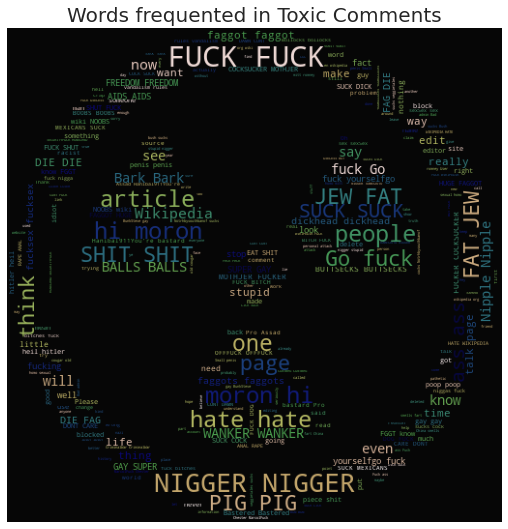

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
stopword=set(STOPWORDS)

#Toxic comment wordcloud
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,mask=hcmask2,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

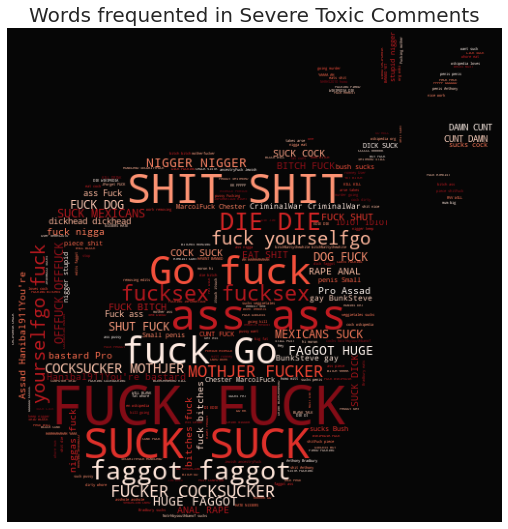

In [ ]:
#severeToxic comment wordcloud
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=hcmask3,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)


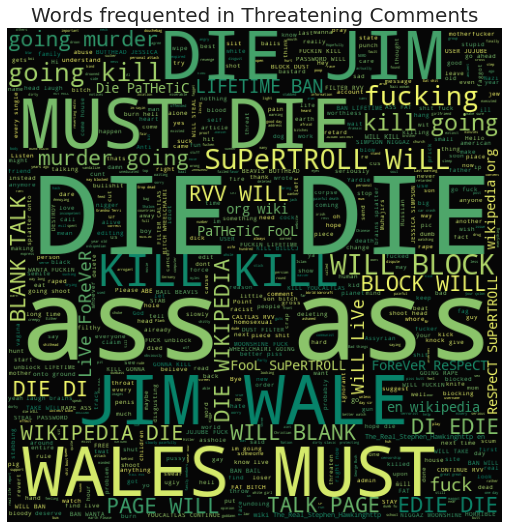

In [ ]:
#Threat comment wordcloud
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=hcmask4,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)


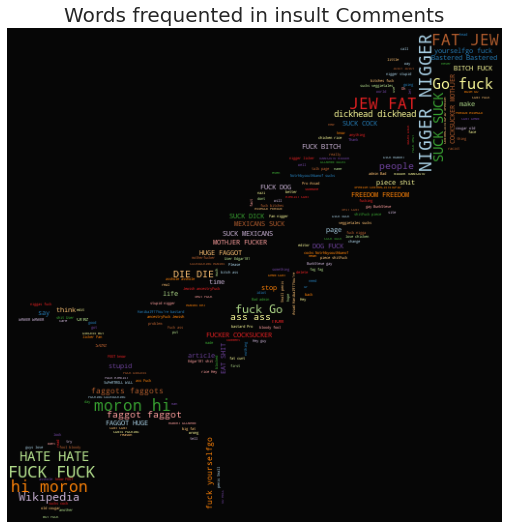

In [ ]:
#insult comments wordcloud
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=hcmask5,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

## Text preprocessing

In [ ]:
!pip install contractions
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('brown')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import re
import string
import contractions

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def tokenize_clean_comment(comment):
    '''
    Params:
        comment: a string containing a comment
    Return:
        comments_clean: a list of words containing the processed comments

    '''
    stemmer = PorterStemmer()
    english_stopwords = stopwords.words('english')

    # remove hyperlinks
    comment = re.sub('https?:\/\/.*[\r\n]*', '', comment)
    #change to lower case
    comment = comment.lower()
    #expand the contraction
    comment = contractions.fix(comment)
    #remove HTML
    comment = re.sub(re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});"), "", comment)
    #remove non-ascii
    comment = re.sub(r'[^\x00-\x7f]',r'', comment)
    # remove share market tickers
    comment = re.sub('\$\w*', '', comment)
    # remove punctuations
    comment = comment.translate(str.maketrans('', '', string.punctuation))

    comment_tokens = word_tokenize(comment)

    comments_cleaned = []
    for word in comment_tokens:
        if word not in english_stopwords:  
            try:
              stem_word = stemmer.stem(word)
              comments_cleaned.append(stem_word)
            except Exception as e:
              print("Unable to stem the word:" + word)
            
    return comments_cleaned

In [ ]:
# Tokenizing the tweet base texts.
from nltk.tokenize import word_tokenize

train['text_clean_tokenize'] = train['comment_text'].apply(lambda x : tokenize_clean_comment(x))
test['text_clean_tokenize'] = test['comment_text'].apply(lambda x : tokenize_clean_comment(x))
train.head()

Unable to stem the word:yyyyyyyyyyyyyyybvgtfrrrrrbyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_clean_tokenize
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"[explan, edit, made, usernam, hardcor, metalli..."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"[daww, match, background, colour, I, seemingli..."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"[hey, man, I, realli, tri, edit, war, guy, con..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"[make, real, suggest, improv, wonder, section,..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"[sir, hero, chanc, rememb, page]"


Lemmatization with POS Tagging

In [ ]:
# Lemmatization with POS tagging
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

lem = WordNetLemmatizer()

wordnet_map = {
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "J": wordnet.ADJ,
    "R": wordnet.ADV
}

# https://stackoverflow.com/a/15590384
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def lemmatize_word_with_POS(text):
    """
        Lemmatize the tokenized words
    """

    pos_tagged_text = nltk.pos_tag(text)

    # map the pos tagging output with wordnet output
    pos_tagged_text = [
        (word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys()
        else (word, wordnet.NOUN)
        for (word, pos_tag) in pos_tagged_text
    ]

    lemma = [lem.lemmatize(word, tag) for word, tag in pos_tagged_text]
    return lemma

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
train['lemmatize_text'] = train['text_clean_tokenize'].apply(lambda x : lemmatize_word_with_POS(x))
train['preprocessed'] = [' '.join(map(str, l)) for l in train['lemmatize_text']] # join back to text
train.head()
test['lemmatize_text'] = test['text_clean_tokenize'].apply(lambda x : lemmatize_word_with_POS(x))
test['preprocessed'] = [' '.join(map(str, l)) for l in test['lemmatize_text']] # join back to text
test.head()

,id,comment_text,text_clean_tokenize,lemmatize_text,preprocessed
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,"[yo, bitch, ja, rule, succes, ever, hate, sad,...","[yo, bitch, ja, rule, succes, ever, hate, sad,...",yo bitch ja rule succes ever hate sad mofuckas...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,"[rfc, titl, fine, I, go]","[rfc, titl, fine, I, go]",rfc titl fine I go
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...","[sourc, zaw, ashton, lapland]","[sourc, zaw, ashton, lapland]",sourc zaw ashton lapland
3,00017563c3f7919a,":If you have a look back at the source, the in...","[look, back, sourc, inform, updat, correct, fo...","[look, back, sourc, inform, updat, correct, fo...",look back sourc inform updat correct form gues...
4,00017695ad8997eb,I don't anonymously edit articles at all.,"[anonym, edit, articl]","[anonym, edit, articl]",anonym edit articl


## Weighted Words

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def TFIDF(data, ngram = 1, MAX_NB_WORDS = 75000):
    tfidf_x = TfidfVectorizer(ngram_range = (ngram, ngram), max_features = MAX_NB_WORDS)
    emb = tfidf_x.fit_transform(data).toarray()
    print("tf-idf with", str(np.array(emb).shape[1]), "features")
    return emb, tfidf_x

In [ ]:
subset_train_preprocessed = train["preprocessed"][:1000]
subset_train = train[:1000]
train_corpus = subset_train_preprocessed.tolist()
train_tfidf_unigram, tfidf_unigram = TFIDF(train_corpus, 1)
train_tfidf_bigram, tfidf_bigram = TFIDF(train_corpus, 2)
train_tfidf_trigram, tfidf_trigram = TFIDF(train_corpus, 3)


tf-idf with 7188 features
tf-idf with 29103 features
tf-idf with 31104 features


In [ ]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids]

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

train_tags = subset_train.iloc[:,2:]

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        print(col)
        feats_df.label = col
        dfs.append(feats_df)
    return dfs

In [ ]:
#get top n for unigrams
tfidf_top_n_per_lass=top_feats_by_class(train_tfidf_unigram, tfidf_unigram.get_feature_names())


toxic
severe_toxic
obscene
threat
insult
identity_hate
text_clean_tokenize
lemmatize_text
preprocessed


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

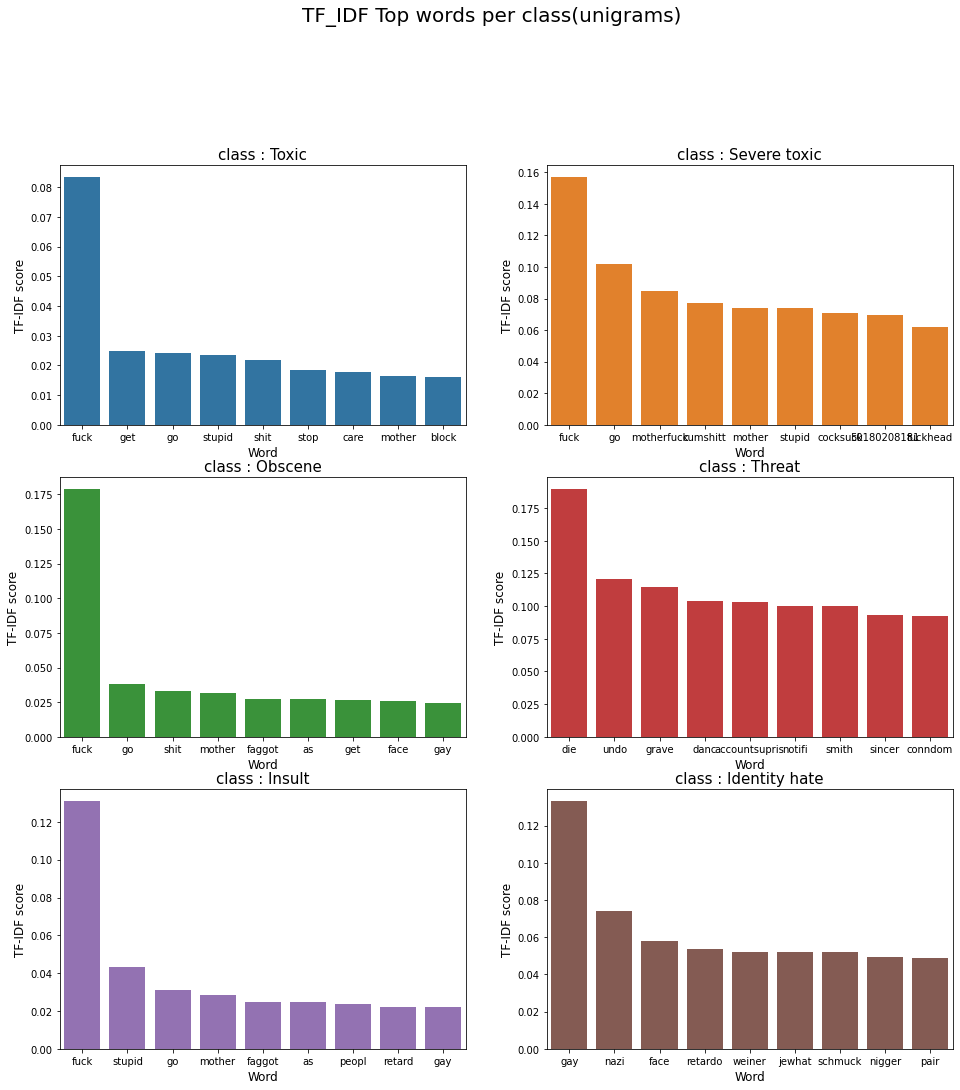

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns

color = sns.color_palette()

plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.show()

## Word2Vec

In [ ]:
# This section is commented out since it takes a very long time to download the large vector file,
# and unfortunately word2vec is not used in the models we picked to work on. If you'd like to see the
# word2vec result, uncomment the whole section to run.

# If you don't have GoogleNews-vectors-negative300.bin already in the same folder
# uncomment the codes below to download the file
# Note it will take a while to finish the download since it's a large 1.5G file

# !pip install wget

# import wget
# url = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
# filename = wget.download(url)

# import gzip
# f_in = gzip.open('GoogleNews-vectors-negative300.bin.gz', 'rb')
# f_out = open('GoogleNews-vectors-negative300.bin', 'wb')
# f_out.writelines(f_in)


# word2vec_path = "GoogleNews-vectors-negative300.bin"

# word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=200000) 


In [ ]:
# def get_average_vec(tokens_list, vector, generate_missing=False, k=300):
#     if len(tokens_list)<1:
#         return np.zeros(k)
    
#     if generate_missing:
#         vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
#     else:
#         vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    
#     length = len(vectorized)
#     summed = np.sum(vectorized, axis=0)
#     averaged = np.divide(summed, length)
#     return averaged

# def get_embeddings(vectors, text, generate_missing=False, k=300):
#     embeddings = text.apply(lambda x: get_average_vec(x, vectors, generate_missing=generate_missing, k=k))
#     return list(embeddings)

In [ ]:
# embeddings_word2vec = get_embeddings(word2vec_model, train["preprocessed"].split(), k=300)

# print("Embedding matrix size", len(embeddings_word2vec), len(embeddings_word2vec[0]))
# print("The sentence: \"%s\" got embedding values: " % train["lemmatized"].split()[0])
# print(embeddings_word2vec[0])

# Model Training

### Logistic Regression

In [ ]:
tags = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_x = train["preprocessed"]
test_x = test["preprocessed"]

In [ ]:
def tweet_counter(output, tweets, tweet_senti):
    '''
    Params:
        output: a dictionary that will be used to map each pair to its frequency
        tweets: a list of tweets (train_x)
        tweet_senti: a list corresponding to the sentiment of each tweet (either 0 or 1) (train_Y)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
 
    for label, tweet in zip(tweet_senti, tweets):
        for word in tweet.split():
            #save key in variable
          word_and_label = (word,label)

          # check if key is in dictionary or not and proceed accordingly
          if word_and_label in output:
            output[word_and_label] += 1
          else:
            output[word_and_label] = 1

    return output


In [ ]:
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    
    # calculate the sigmoid of z
    h = 1 / (1 + np.exp(-z))
    
    return h

In [ ]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    This function should return (J, theta) by taking (x, y, theta, alpha, num_iters) as inputs, where
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
        J: the final cost
        theta: your final weight vector
    '''
    
    # get 'm', the number of rows in matrix x
    m = x.shape[0]
    
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x, theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = -1./m * (np.dot(y.transpose(), np.log(h)) + np.dot((1-y).transpose(),np.log(1-h)))
      
        # update the weights theta
        theta = theta - (alpha/m) * np.dot(x.transpose(),(h-y))
        
    J = float(J)
    return J, theta

In [ ]:
# expected output should match with your output
# Check the function
# Construct a synthetic test case using numpy PRNG functions
np.random.seed(1)
# X input is 10 x 3 with ones for the bias terms
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y Labels are 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)

# Apply gradient descent
tmp_J, tmp_theta = gradientDescent(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 700)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")

The cost after training is 0.67094970.
The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]


In [ ]:
def extract_features(tweet, freqs):
    '''
    This function should take tweet, freqs as input and return x, where:
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = tweet.split()
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3))
    
    #bias term is set to 1
    x[0,0] = 1 
    
    
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word, 1.0),0)
        
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word, 0.0),0)
        
    assert(x.shape == (1, 3))
    return x

In [ ]:
def predict_tweet(tweet, freqs, theta):
    '''
    This function should take (tweet, freqs, theta) as input and return y_pred as output where
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
        y_pred: the probability of a tweet being positive or negative
    '''

    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)    # call extract features function with appropriate parameters 
    
    # make the prediction using x and theta by calling sigmoid function
    y_pred = sigmoid(np.dot(x, theta))
    
    return y_pred

In [ ]:
def test_logistic_regression(test_x, freqs, theta):
    """
    This function should take (test_x, test_y, freqs, theta) as input and return accuracy as output, where
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta) #None  # call predict tweet function with proper parameters
        y_hat.append(y_pred[0])

    return y_hat
    

In [ ]:
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)


submission = pd.read_csv('/root/sample_submission.csv')

all_y = []
def forAllTags(tag):
  train_y = train[tag]
  freqs = tweet_counter({}, train_x, train_y)
  Y = train_y[:, np.newaxis]
  J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 700)
  yForTag = test_logistic_regression(test_x, freqs, theta)
  submission[[tag]] = yForTag
  all_y.append(yForTag)
  return



In [ ]:

for tag in tags:
  forAllTags(tag)
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
submission.head()


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.789373,0.000392,0.116256,3.408027e-07,0.053558,0.000068
1,0000247867823ef7,0.445324,0.042259,0.243313,3.154882e-03,0.218819,0.022867
2,00013b17ad220c46,0.396813,0.241455,0.361943,1.133659e-01,0.371127,0.207951
3,00017563c3f7919a,0.100983,0.000985,0.036641,3.757398e-06,0.042408,0.000299
4,00017695ad8997eb,0.143137,0.003578,0.065127,3.921202e-05,0.073068,0.001361


In [ ]:
submission.to_csv('/root/submission_lr.csv', index=False)

### LightGBM

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
import re

In [ ]:
df_train = train
df_test = test
df_train.rename(columns=({'preprocessed':'comment_text'}))

df_trainnew=pd.DataFrame()
df_trainnew=pd.DataFrame({
    'id':list(df_train.id), 
    'comment_text': list(df_train.preprocessed),
    'toxic': list(df_train.toxic),
    'severe_toxic': list(df_train.severe_toxic),
    'obscene': list(df_train.obscene),
    'threat': list(df_train.threat),
    'insult': list(df_train.insult),
    'identity_hate': list(df_train.identity_hate)
})

In [ ]:
train_text = df_trainnew['comment_text']
test_text = test['comment_text']

data = pd.concat([train_text, test_text], axis=0)
data = pd.DataFrame(data)

In [ ]:
countvec = CountVectorizer(max_features = 1500, ngram_range=(1, 2))
countvecdata = countvec.fit_transform(data['comment_text'])
countvec_df = pd.DataFrame(countvecdata.todense())
countvec_df.columns = ['col' + str(x) for x in countvec_df.columns]
countvec_df_train = countvecdata[:len(train_text)].astype('float32')
countvec_df_test = countvecdata[len(train_text):].astype('float32')

In [ ]:
col = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
preds = np.zeros((test.shape[0], len(col)))

params = {
    'objective' :'binary',
    'learning_rate' : 0.02,
    'num_leaves' : 76,
    'feature_fraction': 0.64, 
    'bagging_fraction': 0.8, 
    'bagging_freq':1,
    'verbose': -1,
    'boosting_type' : 'gbdt',
    'metric': 'binary_logloss'
}

for i, j in enumerate(col):
    print(j)
    X_train, X_valid, Y_train, Y_valid = train_test_split(countvec_df_train,  train[j], random_state=7, test_size=0.33)
    
    d_train = lgbm.Dataset(X_train, Y_train)
    d_valid = lgbm.Dataset(X_valid, Y_valid)
    
    bst = lgbm.train(params, d_train, 5000, valid_sets=[d_valid], verbose_eval=False, early_stopping_rounds=100)
    
    preds[:,i] = bst.predict(countvec_df_test)

In [ ]:
temp = pd.DataFrame(preds, columns = col)
ids = pd.DataFrame({'id': pd.read_csv('sample_submission.csv')["id"]})

lgbm_result = pd.DataFrame({
    'id': list(ids.id),
    'toxic': list(temp.toxic),
    'severe_toxic': list(temp.severe_toxic),
    'obscene': list(temp.obscene),
    'threat': list(temp.threat),
    'insult': list(temp.insult),
    'identity_hate': list(temp.identity_hate)
})
lgbm_result

In [ ]:
subm = pd.read_csv('sample_submission.csv')
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(lgbm_result, columns = col)], axis=1)
submission.to_csv('LGBM_RESULT.csv', index=False)

### LSTM

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GlobalMaxPool1D, Bidirectional, Conv1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

max_features = 60000
max_len = 150
embed_size = 128

tags = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
tags_matrix = train[tags].values

In [ ]:
#Tokenize the corpus using Keras Library
corpus = train["comment_text"]
test_data = test["comment_text"]
keras_tokenizer = Tokenizer(num_words=max_features)
keras_tokenizer.fit_on_texts(list(corpus))
keras_tokenizer.fit_on_texts(list(test_data))
tokenized_corpus = keras_tokenizer.texts_to_sequences(corpus)
tokenized_test = keras_tokenizer.texts_to_sequences(test_data)

In [ ]:
# unidirectional LSTM
#Add padding and build the model
padded_corpus = pad_sequences(tokenized_corpus, maxlen=max_len)
padded_test = pad_sequences(tokenized_test, maxlen=max_len)
inputs = Input(shape=(max_len, ))
outputs = Embedding(max_features, embed_size)(inputs)
outputs = LSTM(60, return_sequences=True, name='lstm_layer')(outputs)
outputs = GlobalMaxPool1D()(outputs)
outputs = Dropout(0.1)(outputs)
outputs = Dense(50, activation="relu")(outputs)
outputs = Dropout(0.1)(outputs)
outputs = Dense(6, activation="sigmoid")(outputs)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

#Train and test
model.fit(padded_corpus, tags_matrix, batch_size=32, epochs=2, validation_split=0.1)
pred = model.predict(padded_test, batch_size=1024, verbose=1)

submission = pd.read_csv('/root/sample_submission.csv')
submission[tags] = pred
submission.to_csv('/root/submission_lstm.csv', index=False)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 150, 128)          7680000   
                                                                 
 lstm_layer (LSTM)           (None, 150, 60)           45360     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 60)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3050      
                                                           

In [ ]:
#Bidirectional LSTM
#build the model
inputs_bi = Input(shape=(max_len, ))
outputs_bi = Embedding(max_features, embed_size)(inputs_bi)
outputs_bi = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(outputs_bi)
outputs_bi = GlobalMaxPool1D()(outputs_bi)
outputs_bi = Dropout(0.1)(outputs_bi)
outputs_bi = Dense(50, activation="relu")(outputs_bi)
outputs_bi = Dropout(0.1)(outputs_bi)
outputs_bi = Dense(6, activation="sigmoid")(outputs_bi)

model_bi = Model(inputs=inputs_bi, outputs=outputs_bi)
model_bi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bi.summary()

file_path="/root/helper"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True)
early = EarlyStopping(monitor="val_loss",patience=20)

#Train and test
model.fit(padded_corpus, tags_matrix, batch_size=32, epochs=2, validation_split=0.1, callbacks=[checkpoint, early])
pred_bi = model.predict(padded_test, batch_size=1024,verbose=1)

submission_bi = pd.read_csv('/root/sample_submission.csv')
submission_bi[tags] = pred_bi
submission_bi.to_csv('/root/submission_lstm_bi.csv', index=False)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 150, 128)          7680000   
                                                                 
 conv1d_3 (Conv1D)           (None, 148, 256)          98560     
                                                                 
 bidirectional_3 (Bidirectio  (None, 148, 100)         122800    
 nal)                                                            
                                                                 
 global_max_pooling1d_5 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_10 (Dropout)        (None, 100)               0   

# Evaluation

## Standard Accuracy evaluation

In [ ]:
from sklearn.metrics import accuracy_score

test_labels = pd.read_csv("/root/test_labels.csv")

submission_lr = pd.read_csv('/root/submission_lr.csv')
submission_lgbm = pd.read_csv('/root/submission_lgbm.csv')
submission_lstm = pd.read_csv('/root/submission_lstm.csv')
submission_lstm_bi = pd.read_csv('/root/submission_lstm_bi.csv')

def eval_preprocess(label_file, submission_file):
  test_results = pd.DataFrame({
      'id': list(label_file.id),
      'toxic_res': list(label_file.toxic),
      'severe_toxic_res': list(label_file.severe_toxic),
      'obscene_res': list(label_file.obscene),
      'threat_res': list(label_file.threat),
      'insult_res': list(label_file.insult),
      'identity_hate_res': list(label_file.identity_hate)
  })

  pred_results = pd.DataFrame({
      'id': list(submission_file.id),
      'toxic': list(submission_file.toxic),
      'severe_toxic': list(submission_file.severe_toxic),
      'obscene': list(submission_file.obscene),
      'threat': list(submission_file.threat),
      'insult': list(submission_file.insult),
      'identity_hate': list(submission_file.identity_hate)
  })

  total_results = pred_results.set_index('id').join(test_results.set_index('id'))
  scores = []

  # Remove -1 rows that are not scored
  result_compare = total_results[(total_results['toxic_res'] != -1)] * 1.0
  result_compare[result_compare >= 0.5] = 1
  result_compare[result_compare < 0.5] = 0
  return result_compare

def get_accuracy(label_file, submission_file):
  result_compare = eval_preprocess(label_file, submission_file);
  total = 0
  for tag in tags:
    label_name = tag + '_res'
    score = accuracy_score(result_compare[label_name].to_numpy(), result_compare[tag].to_numpy())
    total += score
  print("Stanard accuracy score is: " + str(total / 6))



In [ ]:
print("For Logistic Regression")
get_accuracy(test_labels, submission_lr)
print("For LightGBM")
get_accuracy(test_labels, submission_lgbm)
print("For LSTM")
get_accuracy(test_labels, submission_lstm)
print("For Bidirectional LSTM")
get_accuracy(test_labels, submission_lstm_bi)

For Logistic Regression
Stanard accuracy score is: 0.9669886523492451
For LightGBM
Stanard accuracy score is: 0.9328428981737386
For LSTM
Stanard accuracy score is: 0.965368303687726
For Bidirectional LSTM
Stanard accuracy score is: 0.9727510498400491


## AUC score evaluation

In [ ]:
from sklearn import metrics

def get_auc_score(label_file, submission_file):

  result_compare = eval_preprocess(label_file, submission_file);
  # result for each tag
  for tag in tags:
      label_name = tag + '_res'
      fpr, tpr,thresholds = metrics.roc_curve(result_compare[label_name].to_numpy(), result_compare[tag].to_numpy())
      score = metrics.auc(fpr, tpr)
      print("AUC score for " + tag + " is: " + str(score))


In [ ]:
print("For Logistic Regression")
get_auc_score(test_labels, submission_lr)
print("For LightGBM")
get_auc_score(test_labels, submission_lgbm)
print("For LSTM")
get_auc_score(test_labels, submission_lstm)
print("For Bidirectional LSTM")
get_auc_score(test_labels, submission_lstm_bi)


For Logistic Regression
AUC score for toxic is: 0.7433655392305032
AUC score for severe_toxic is: 0.49992925751835376
AUC score for obscene is: 0.6819705477524902
AUC score for threat is: 0.5
AUC score for insult is: 0.5926332736115388
AUC score for identity_hate is: 0.49999209686087315
For LightGBM
AUC score for toxic is: 0.7289365645934422
AUC score for severe_toxic is: 0.571809799342951
AUC score for obscene is: 0.7150629478028194
AUC score for threat is: 0.5433558718356226
AUC score for insult is: 0.7416965374959373
AUC score for identity_hate is: 0.6082676427214242
For LSTM
AUC score for toxic is: 0.8907099780925695
AUC score for severe_toxic is: 0.6607340717937453
AUC score for obscene is: 0.8710129624386723
AUC score for threat is: 0.5
AUC score for insult is: 0.8381133249928145
AUC score for identity_hate is: 0.50418187058956
For Bidirectional LSTM
AUC score for toxic is: 0.8438085724225072
AUC score for severe_toxic is: 0.6619942860293087
AUC score for obscene is: 0.8518128518